### Imports

In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, InMemoryDataset
from torchinfo import summary
from torch.utils.data import random_split

from tqdm import tqdm, trange

import pyvista as pv

from utils.sph_harm_functions import stl_maker

In [2]:
device = "cpu"

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

print(f"Using device: {device}")

Using device: mps


In [3]:
# Configuration flags for training models.
TRAINING = False  # Flag to indicate if the training process should be executed.
TRAINING_OVERFIT = False  # Flag to indicate if the training should focus on overfitting for debugging purposes.
TRAINING_BASELINE = (
    False  # Flag to indicate if the baseline training should be performed.
)

### Models

#### EGNN

In [4]:
def unsorted_segment_sum(data, segment_ids, num_segments):
    """
    Computes the sum of elements along segments of a tensor.

    Args:
        data (torch.Tensor): The input tensor containing the data to be summed.
        segment_ids (torch.Tensor): A tensor containing segment IDs for each element in `data`.
        num_segments (int): The number of distinct segments.

    Returns:
        torch.Tensor: A tensor where each element is the sum of the elements in the corresponding segment.
    """
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Initialize empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    """
    Computes the mean of segments of a tensor.

    Args:
        data (torch.Tensor): The input tensor containing the data to be segmented.
        segment_ids (torch.Tensor): A tensor containing the segment IDs for each element in `data`.
        num_segments (int): The number of segments.

    Returns:
        torch.Tensor: A tensor containing the mean of each segment.
    """
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Initialize empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)


def apply_periodic_boundary_conditions(coord, box_size):
    """
    Apply periodic boundary conditions to a coordinate.

    This function ensures that the given coordinate is wrapped within the
    boundaries defined by the box size.

    Args:
        coord (float or array-like): The coordinate(s) to be wrapped.
        box_size (float): The size of the box defining the periodic boundaries.

    Returns:
        float or array-like: The coordinate(s) after applying periodic boundary conditions.
    """
    coord = coord % box_size
    return coord


class E_GCL(nn.Module):
    def __init__(
        self,
        input_nf,
        hidden_nf,
        edges_in_d=0,
        nodes_att_dim=0,
        act_fn=nn.ReLU(),
        residual=True,
        coords_weight=1.0,
        attention=False,
        norm_diff=False,
        tanh=False,
        device="cpu",
        dropout=0.0,
        models_depth=1,
        box_size=1.0,
    ):
        """
        Initialize the E_GCL layer.

        Args:
            input_nf (int): Number of input node features.
            hidden_nf (int): Number of hidden features.
            edges_in_d (int, optional): Dimension of edge features. Default is 0.
            nodes_att_dim (int, optional): Dimension of node attributes. Default is 0.
            act_fn (callable, optional): Activation function. Default is nn.ReLU().
            residual (bool, optional): Whether to use residual connections. Default is True.
            coords_weight (float, optional): Weight for coordinate updates. Default is 1.0.
            attention (bool, optional): Whether to use attention mechanism. Default is False.
            norm_diff (bool, optional): Whether to normalize coordinate differences. Default is False.
            tanh (bool, optional): Whether to apply tanh activation to coordinate updates. Default is False.
            device (str, optional): Device to use ('cpu' or 'cuda'). Default is 'cpu'.
            dropout (float, optional): Dropout rate. Default is 0.0.
            box_size (float, optional): Size of the periodic box. Default is 1.0.
            models_depth (int, optional): Depth of the MLP models. Default is 1.
        """
        super(E_GCL, self).__init__()
        input_edge = input_nf * 2
        self.device = device
        self.coords_weight = coords_weight
        self.residual = residual
        self.attention = attention
        self.norm_diff = norm_diff
        self.tanh = tanh
        self.box_size = box_size
        edge_coords_nf = 1  # Squared distance

        edge_mlp = [
            nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
            self.dropout_layer(dropout),
            act_fn,
        ]
        for _ in range(models_depth):
            edge_mlp.append(nn.Linear(hidden_nf, hidden_nf))
            edge_mlp.append(act_fn)

        self.edge_mlp = nn.Sequential(*edge_mlp).to(self.device)

        node_mlp = [
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
            self.dropout_layer(dropout),
        ]
        for _ in range(models_depth):
            node_mlp.append(act_fn)
            node_mlp.append(nn.Linear(hidden_nf, hidden_nf))

        self.node_mlp = nn.Sequential(*node_mlp).to(self.device)

        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        coord_mlp = [
            nn.Linear(hidden_nf, hidden_nf),
            self.dropout_layer(dropout),
            act_fn,
        ]
        for _ in range(models_depth - 1):
            coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))
            coord_mlp.append(act_fn)

        coord_mlp.append(layer)

        if self.tanh:
            coord_mlp.append(nn.Tanh())
            self.coords_range = nn.Parameter(torch.ones(1)) * 3
        self.coord_mlp = nn.Sequential(*coord_mlp).to(self.device)

        if self.attention:
            self.att_mlp = nn.Sequential(nn.Linear(hidden_nf, 1), nn.Sigmoid()).to(
                self.device
            )

    def dropout_layer(self, dropout):
        """
        Return a dropout layer if dropout rate is greater than 0.

        Args:
            dropout (float): Dropout rate.

        Returns:
            nn.Module: Dropout layer or identity layer.
        """
        return nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def edge_model(self, source, target, radial, edge_attr):
        """
        Compute edge features.

        Args:
            source (torch.Tensor): Source node features.
            target (torch.Tensor): Target node features.
            radial (torch.Tensor): Radial distances between nodes.
            edge_attr (torch.Tensor or None): Edge attributes.

        Returns:
            torch.Tensor: Updated edge features.
        """
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1).to(self.device)
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1).to(self.device)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_attr, node_attr):
        """
        Update node features.

        Args:
            x (torch.Tensor): Node features.
            edge_index (torch.Tensor): Edge indices.
            edge_attr (torch.Tensor): Edge features.
            node_attr (torch.Tensor or None): Node attributes.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Updated node features and aggregated messages.
        """
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        if self.residual:
            out = x + out
        return out, agg

    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        """
        Update node coordinates.

        Args:
            coord (torch.Tensor): Node coordinates.
            edge_index (torch.Tensor): Edge indices.
            coord_diff (torch.Tensor): Coordinate differences between nodes.
            edge_feat (torch.Tensor): Edge features.

        Returns:
            torch.Tensor: Coordinate updates.
        """
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        trans = torch.clamp(
            trans, min=-100, max=100
        )  # This is never activated but just in case it explodes, it may save the train
        agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        return agg * self.coords_weight

    def coord2radial(self, edge_index, coord):
        """
        Compute radial distances and coordinate differences.

        Args:
            edge_index (torch.Tensor): Edge indices.
            coord (torch.Tensor): Node coordinates.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Radial distances and coordinate differences.
        """
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum((coord_diff) ** 2, 1).unsqueeze(1)

        if self.norm_diff:
            norm = torch.sqrt(radial) + 1
            coord_diff = coord_diff / norm

        return radial, coord_diff

    def periodic_delta_position(self, positions, row, col, box_size=1.0):
        """
        Compute periodic coordinate differences between nodes.

        Args:
            positions (torch.Tensor): Node positions.
            row (torch.Tensor): Source node indices.
            col (torch.Tensor): Target node indices.
            box_size (float, optional): Size of the periodic box. Default is 1.0.

        Returns:
            torch.Tensor: Periodic coordinate differences.
        """
        delta = positions[row] - positions[col]
        sign = torch.sign(delta)
        delta = torch.abs(delta)
        out = torch.min(delta, box_size - delta)
        out *= sign
        return out

    def coord2radial_pbc(self, edge_index, coord):
        """
        Calculates the radial distance between pairs of points with periodic boundary conditions (PBC).

        Args:
            edge_index (torch.Tensor): Indices of the edges (row, col).
            coord (torch.Tensor): Node coordinates.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Radial distances and coordinate differences corrected for PBC.
        """
        row, col = edge_index

        periodic_delta_position = self.periodic_delta_position(
            coord, row, col, self.box_size
        )

        radial = torch.sum(periodic_delta_position**2, dim=1, keepdim=True)

        if self.norm_diff:
            norm = (
                torch.sqrt(radial) + 1e-8
            )  # Add a small epsilon to avoid division by zero
            periodic_delta_position = periodic_delta_position / norm

        return radial, periodic_delta_position

    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None):
        """
        Forward pass of the E_GCL layer.

        Args:
            h (torch.Tensor): Node features.
            edge_index (torch.Tensor): Edge indices.
            coord (torch.Tensor): Node coordinates.
            edge_attr (torch.Tensor, optional): Edge attributes.
            node_attr (torch.Tensor, optional): Node attributes.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Updated node features, coordinates, and edge attributes.
        """
        row, col = edge_index
        radial, coord_diff = self.coord2radial_pbc(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = coord + self.coord_model(coord, edge_index, coord_diff, edge_feat)
        coord = apply_periodic_boundary_conditions(coord, self.box_size)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        return h, coord, edge_attr


class E_GCL_Bubbles(E_GCL):
    def __init__(
        self,
        input_nf,
        hidden_nf,
        edges_in_d=0,
        nodes_att_dim=0,
        act_fn=nn.ReLU(),
        residual=True,
        coords_weight=1.0,
        attention=False,
        norm_diff=False,
        tanh=False,
        device="cpu",
        dropout=0.0,
        models_depth=1,
        box_size=1.0,
    ):
        """
        Initialize the E_GCL_Bubbles layer.

        Args:
            Same as E_GCL.__init__().
        """
        E_GCL.__init__(
            self,
            input_nf,
            hidden_nf,
            edges_in_d=edges_in_d,
            nodes_att_dim=nodes_att_dim,
            act_fn=act_fn,
            residual=residual,
            coords_weight=coords_weight,
            attention=attention,
            norm_diff=norm_diff,
            tanh=tanh,
            device=device,
            dropout=dropout,
            models_depth=models_depth,
            box_size=box_size,
        )

        coord_mlp_vel = [
            nn.Linear(input_nf, hidden_nf),
            self.dropout_layer(dropout),
            act_fn,
        ]
        for _ in range(models_depth - 1):
            coord_mlp_vel.append(nn.Linear(hidden_nf, hidden_nf))
            coord_mlp_vel.append(act_fn)

        coord_mlp_vel.append(nn.Linear(hidden_nf, 1))

        self.coord_mlp_vel = nn.Sequential(*coord_mlp_vel).to(self.device)

        coord_mlp_orbs = [
            nn.Linear(input_nf, hidden_nf),
            self.dropout_layer(dropout),
            act_fn,
        ]
        for _ in range(models_depth - 1):
            coord_mlp_orbs.append(nn.Linear(hidden_nf, hidden_nf))
            coord_mlp_orbs.append(act_fn)

        coord_mlp_orbs.append(nn.Linear(hidden_nf, 1))
        self.coord_mlp_orbs = nn.Sequential(*coord_mlp_orbs).to(self.device)

        phi_xorb = [
            nn.Linear(hidden_nf, hidden_nf),
            self.dropout_layer(dropout),
            act_fn,
        ]
        for _ in range(models_depth - 1):
            phi_xorb.append(nn.Linear(hidden_nf, hidden_nf))
            phi_xorb.append(act_fn)

        phi_xorb.append(nn.Linear(hidden_nf, 1))
        phi_xorb.append(nn.Tanh() if self.tanh else nn.Identity())

        self.phi_xorb = nn.Sequential(*phi_xorb).to(self.device)

    def orbs_model(self, coord, edge_index, coord_diff, edge_feat, orbs):
        """
        Update orbital features.

        Args:
            coord (torch.Tensor): Node coordinates.
            edge_index (torch.Tensor): Edge indices.
            coord_diff (torch.Tensor): Coordinate differences between nodes.
            edge_feat (torch.Tensor): Edge features.
            orbs (torch.Tensor): Orbital features.

        Returns:
            torch.Tensor: Updated orbital features.
        """
        row, col = edge_index

        dist_squared = torch.sum(coord_diff**2, dim=1, keepdim=True)

        # Node orbitals
        orbs_i = orbs[row]
        orbs_j = orbs[col]
        orbs_diff = orbs_i - orbs_j  # [num_edges, num_orbitals]

        trans = (
            dist_squared * self.phi_xorb(edge_feat) * orbs_diff
        )  # [num_edges, num_orbitals]

        trans = torch.clamp(
            trans, min=-100, max=100
        )  # This is never activated but just in case it explodes, it may save the train

        agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))

        agg = agg * self.coords_weight
        return agg

    def forward(self, h, edge_index, coord, vel, orbs, edge_attr=None, node_attr=None):
        """
        Forward pass of the E_GCL_Bubbles layer.

        Args:
            h (torch.Tensor): Node features.
            edge_index (torch.Tensor): Edge indices.
            coord (torch.Tensor): Node coordinates.
            vel (torch.Tensor): Node velocities.
            orbs (torch.Tensor): Orbital features.
            edge_attr (torch.Tensor, optional): Edge attributes.
            node_attr (torch.Tensor, optional): Node attributes.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
                Updated node features, coordinates, velocities, orbitals, and edge attributes.
        """
        h = h.to(self.device)
        edge_index = edge_index.to(self.device)
        coord = coord.to(self.device)
        vel = vel.to(self.device)
        orbs = orbs.to(self.device)
        if edge_attr is not None:
            edge_attr = edge_attr.to(self.device)

        if node_attr is not None:
            node_attr = node_attr.to(self.device)

        row, col = edge_index
        row, col = row.to(self.device), col.to(self.device)

        radial, coord_diff = self.coord2radial_pbc(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)

        coord_weighted_average = self.coord_model(
            coord, edge_index, coord_diff, edge_feat
        )

        vel = coord_weighted_average + self.coord_mlp_vel(h) * vel

        orbs = self.coord_mlp_orbs(h) * orbs + self.orbs_model(
            coord, edge_index, coord_diff, edge_feat, orbs
        )

        coord = coord + vel

        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)

        return h, coord, vel, orbs, edge_attr


class EGNN_Bubbles(torch.nn.Module):
    def __init__(
        self,
        hidden_nf,
        in_edge_nf=0,
        nodes_att_dim=0,
        act_fn=torch.nn.SiLU(),
        residual=True,
        coords_weight=1.0,
        attention=False,
        norm_diff=False,
        tanh=False,
        device="cpu",
        dropout=0.0,
        n_layers=4,
        in_emb_depth=1,
        models_depth=1,
        box_size=1.0,
    ):
        """
        Initialize the EGNN_Bubbles model.

        Args:
            hidden_nf (int): Number of hidden features.
            in_edge_nf (int, optional): Input edge feature dimension. Default is 0.
            nodes_att_dim (int, optional): Node attribute dimension. Default is 0.
            act_fn (callable, optional): Activation function. Default is torch.nn.SiLU().
            residual (bool, optional): Whether to use residual connections. Default is True.
            coords_weight (float, optional): Weight for coordinate updates. Default is 1.0.
            attention (bool, optional): Whether to use attention mechanism. Default is False.
            norm_diff (bool, optional): Whether to normalize coordinate differences. Default is False.
            tanh (bool, optional): Whether to apply tanh activation to coordinate updates. Default is False.
            device (str, optional): Device to use ('cpu' or 'cuda'). Default is 'cpu'.
            dropout (float, optional): Dropout rate. Default is 0.0.
            n_layers (int, optional): Number of layers. Default is 4.
            in_emb_depth (int, optional): Depth of input embedding layers. Default is 1.
            models_depth (int, optional): Depth of the MLP models. Default is 1.
        """
        super(EGNN_Bubbles, self).__init__()

        self.device = device
        self.n_layers = n_layers

        # Initial linear layer to transform input node features to the hidden dimension

        in_emb_layers = [
            torch.nn.Linear(nodes_att_dim, hidden_nf, device=self.device),
            act_fn,
        ]

        for _ in range(in_emb_depth - 1):
            in_emb_layers.append(
                torch.nn.Linear(hidden_nf, hidden_nf, device=self.device)
            )
            in_emb_layers.append(act_fn)

        self.in_emb = torch.nn.Sequential(*in_emb_layers)

        for i in range(0, n_layers):
            self.add_module(
                "gcl_%d" % i,
                E_GCL_Bubbles(
                    hidden_nf,
                    hidden_nf,
                    edges_in_d=in_edge_nf,
                    nodes_att_dim=nodes_att_dim,
                    act_fn=act_fn,
                    residual=residual,
                    coords_weight=coords_weight,
                    attention=attention,
                    norm_diff=norm_diff,
                    tanh=tanh,
                    device=self.device,
                    dropout=dropout,
                    models_depth=models_depth,
                    box_size=box_size,
                ),
            )
        self.to(self.device)

    def forward(self, data):
        """
        Forward pass of the EGNN_Bubbles model.

        Args:
            data (torch_geometric.data.Data): Input graph data containing node attributes, positions, velocities,
                                              orbitals, edge indices, and edge attributes.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Updated positions, velocities, and orbitals.
        """
        data = data.to(self.device)

        h = self.in_emb(data.node_attr)  # Embed node_attr as a feature

        # Get the positions, velocities, and orbitals
        positions, velocity, orbs = data.x[0], data.x[1], data.x[2]

        edge_index = data.edge_index
        edge_attr = data.edge_attr
        node_attr = data.node_attr

        # Predict new velocities and orbitals
        for i in range(0, self.n_layers):
            h, positions, velocity, orbs, _ = self._modules["gcl_%d" % i](
                h,
                edge_index,
                positions,
                velocity,
                orbs,
                edge_attr=edge_attr,
                node_attr=node_attr,
            )
        return positions, velocity, orbs

#### Baseline

In [5]:
class MessagePassingLayerBubbles(torch.nn.Module):
    def __init__(
        self,
        node_hidden_dim,
        edge_in_dim,
        models_depth=1,
        device="cpu",
        act_fn=nn.ReLU(),
        dropout=0.0,
    ):
        """
        A custom message passing layer for graph neural networks.

        Args:
            node_hidden_dim (int): Dimension of node hidden features.
            edge_in_dim (int): Dimension of edge input features.
            models_depth (int, optional): Depth of the MLP models. Default is 1.
            device (str, optional): Device to use ('cpu' or 'cuda'). Default is 'cpu'.
            act_fn (callable, optional): Activation function. Default is nn.ReLU().
            dropout (float, optional): Dropout rate. Default is 0.0.
        """
        super(MessagePassingLayerBubbles, self).__init__()

        message_mlp = [
            nn.Linear(node_hidden_dim + edge_in_dim, node_hidden_dim),
            self.dropout_layer(dropout),
            act_fn,
            nn.Linear(node_hidden_dim, node_hidden_dim),
        ]
        for _ in range(models_depth - 1):
            message_mlp.append(act_fn)
            message_mlp.append(nn.Linear(node_hidden_dim, node_hidden_dim))

        self.message_mlp = nn.Sequential(*message_mlp).to(device)

        update_mlp = [
            nn.Linear(node_hidden_dim + node_hidden_dim, node_hidden_dim),
            self.dropout_layer(dropout),
            act_fn,
            nn.Linear(node_hidden_dim, node_hidden_dim),
        ]
        for _ in range(models_depth - 1):
            update_mlp.append(act_fn)
            update_mlp.append(nn.Linear(node_hidden_dim, node_hidden_dim))

        self.update_mlp = nn.Sequential(*update_mlp).to(device)

    def dropout_layer(self, dropout):
        """
        Returns a dropout layer if dropout rate is greater than 0.

        Args:
            dropout (float): Dropout rate.

        Returns:
            nn.Module: Dropout layer or identity layer.
        """
        return nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x, edge_index, edge_attr):
        """
        Forward pass of the message passing layer.

        Args:
            x (torch.Tensor): Node features of shape [num_nodes, node_hidden_dim].
            edge_index (torch.Tensor): Edge indices of shape [2, num_edges].
            edge_attr (torch.Tensor): Edge attributes of shape [num_edges, edge_in_dim].

        Returns:
            torch.Tensor: Updated node features.
        """
        row, col = edge_index  # Source and target node indices

        # Extract node features for each edge
        x_i = x[col]  # Source node features
        x_j = x[row]  # Target node features

        # Concatenate target node features with edge attributes
        edge_inputs = torch.cat(
            [x_j, edge_attr], dim=1
        )  # [num_edges, node_hidden_dim + edge_in_dim]

        # Compute messages
        messages = self.message_mlp(edge_inputs)  # [num_edges, node_hidden_dim]

        # Aggregate messages for each target node
        aggregated_messages = torch.zeros(x.size(0), messages.size(1)).to(x.device)
        aggregated_messages.index_add_(0, row, messages)  # Sum messages for each node

        # Update node features
        x_updated = torch.cat([x, aggregated_messages], dim=1)
        x = self.update_mlp(x_updated)

        return x


class MPNNBaseline(torch.nn.Module):
    def __init__(
        self,
        num_layers=3,
        in_emb_depth=1,
        models_depth=1,
        hidden_nf=64,
        node_input_dim=22,
        node_attr_dim=2,
        edge_input_dim=6,
        node_output_dim=22,
        device="cpu",
        act_fn=nn.ReLU(),
        dropout=0.0,
    ):
        """
        Baseline Message Passing Neural Network (MPNN) model with multiple message passing layers.

        Args:
            num_layers (int, optional): Number of message passing layers. Default is 3.
            in_emb_depth (int, optional): Depth of the input embedding layers. Default is 1.
            models_depth (int, optional): Depth of the MLP models in each layer. Default is 1.
            hidden_nf (int, optional): Dimension of the hidden features. Default is 64.
            node_input_dim (int, optional): Dimension of the input node features. Default is 22.
            node_attr_dim (int, optional): Dimension of the node attributes. Default is 2.
            edge_input_dim (int, optional): Dimension of the input edge features. Default is 6.
            node_output_dim (int, optional): Dimension of the output node features. Default is 22.
            device (str, optional): Device to use ('cpu' or 'cuda'). Default is 'cpu'.
            act_fn (callable, optional): Activation function. Default is nn.ReLU().
            dropout (float, optional): Dropout rate. Default is 0.0.
        """
        super(MPNNBaseline, self).__init__()
        self.num_layers = num_layers

        # Define the initial embedding layer
        in_emb_layers = [
            torch.nn.Linear(node_attr_dim + node_input_dim, hidden_nf, device=device),
            act_fn,
        ]

        for i in range(in_emb_depth - 1):
            in_emb_layers.append(torch.nn.Linear(hidden_nf, hidden_nf, device=device))
            in_emb_layers.append(act_fn)

        self.in_emb = torch.nn.Sequential(*in_emb_layers).to(device)

        # Define the message passing layers
        self.layers = torch.nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(
                MessagePassingLayerBubbles(
                    hidden_nf,
                    edge_input_dim,
                    models_depth=models_depth,
                    device=device,
                    act_fn=act_fn,
                    dropout=dropout,
                )
            )

        # Define the final output layer
        self.output_mlp = nn.Sequential(nn.Linear(hidden_nf, node_output_dim)).to(
            device
        )

    def forward(self, data):
        """
        Forward pass of the MPNN model.

        Args:
            data (torch_geometric.data.Data): Input data containing node features, edge indices, edge attributes, and node attributes.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Updated positions, velocities, and orbitals.
        """
        positions, velocity, orbs = data.x[0], data.x[1], data.x[2]
        x = torch.cat([positions, velocity, orbs], dim=1)

        edge_index = data.edge_index
        edge_attr = data.edge_attr
        node_attr = data.node_attr

        input_x_attr = torch.cat([x, node_attr], dim=1)

        h = self.in_emb(input_x_attr)  # Initial node embedding

        for layer in self.layers:
            h = layer(h, edge_index, edge_attr)

        out = self.output_mlp(h)

        positions, velocity, orbs = out[:, :3], out[:, 3:6], out[:, 6:]

        return positions, velocity, orbs

### Losses

In [6]:
class MSE_vel(torch.nn.Module):
    def __init__(self):
        """
        Mean Squared Error loss function for velocity only.
        """
        super(MSE_vel, self).__init__()

    def forward(self, y_pred, y_true):
        """
        Computes the Mean Squared Error (MSE) loss between predicted and true velocities.

        Expected input format for `y_pred` and `y_true`: (Positions, Velocities, Harmonics)

        Args:
            y_pred (tuple): Tuple containing predicted tensors.
            y_true (tuple): Tuple containing true tensors.

        Returns:
            torch.Tensor: Computed MSE loss.
        """
        # Extract velocities
        y_pred_vel = y_pred[1]
        y_true_vel = y_true[1]

        # Compute MSE loss
        mse_loss = torch.mean((y_pred_vel - y_true_vel) ** 2)

        return mse_loss


class MSE_harmonics(torch.nn.Module):
    def __init__(self, orb_weight=1.0):
        """
        Mean Squared Error loss function for velocities and harmonics with uniform weighting.

        Args:
            orb_weight (float): Weight applied to the harmonic components. Default is 1.0.
        """
        super(MSE_harmonics, self).__init__()
        self.orb_weight = orb_weight

    def forward(self, y_pred, y_true):
        """
        Computes the Mean Squared Error (MSE) loss between predicted and true velocities and harmonics.

        Expected input format for `y_pred` and `y_true`: (Positions, Velocities, Harmonics)

        Args:
            y_pred (tuple): Tuple containing predicted tensors.
            y_true (tuple): Tuple containing true tensors.

        Returns:
            torch.Tensor: Computed MSE loss.
        """
        # Extract velocities
        y_pred_vel = y_pred[1]
        y_true_vel = y_true[1]

        # Apply weight to harmonics
        orbs_pred_weighted = y_pred[2] * self.orb_weight
        orbs_true_weighted = y_true[2] * self.orb_weight

        # Concatenate velocities and weighted harmonics
        y_pred_cat = torch.cat([y_pred_vel, orbs_pred_weighted], dim=1)
        y_true_cat = torch.cat([y_true_vel, orbs_true_weighted], dim=1)

        # Compute MSE loss
        mse_loss = torch.mean((y_pred_cat - y_true_cat) ** 2)

        return mse_loss


class MSE_harmonics_linear_weight(torch.nn.Module):
    def __init__(self, orb_weight=1.0):
        """
        Mean Squared Error loss function with linearly decreasing weights for harmonics.

        Args:
            orb_weight (float): Base weight applied to the harmonic components. Default is 1.0.
        """
        super(MSE_harmonics_linear_weight, self).__init__()
        self.orb_weight = orb_weight

    def forward(self, y_pred, y_true):
        """
        Computes the Mean Squared Error (MSE) loss between predicted and true velocities and harmonics,
        applying linearly decreasing weights to the harmonics.

        Expected input format for `y_pred` and `y_true`: (Positions, Velocities, Harmonics)

        Args:
            y_pred (tuple): Tuple containing predicted tensors.
            y_true (tuple): Tuple containing true tensors.

        Returns:
            torch.Tensor: Computed MSE loss.
        """
        # Extract velocities
        y_pred_vel = y_pred[1]
        y_true_vel = y_true[1]

        # Number of harmonics
        num_orbitals = y_pred[2].shape[1]  # Should be 16

        # Ensure the number of harmonics is as expected
        assert (
            num_orbitals == 16
        ), f"Number of orbitals should be 16, found {num_orbitals}"

        # Create linearly decreasing weights
        weights = torch.linspace(
            1.0, 0.1, steps=num_orbitals, device=y_pred[2].device
        ).view(1, -1)

        # Apply weights to harmonics
        orbs_pred_weighted = y_pred[2] * weights * self.orb_weight
        orbs_true_weighted = y_true[2] * weights * self.orb_weight

        # Concatenate velocities and weighted harmonics
        y_pred_cat = torch.cat([y_pred_vel, orbs_pred_weighted], dim=1)
        y_true_cat = torch.cat([y_true_vel, orbs_true_weighted], dim=1)

        # Compute MSE loss
        mse_loss = torch.mean((y_pred_cat - y_true_cat) ** 2)

        return mse_loss


class MSE_harmonics_only(torch.nn.Module):
    def __init__(self, orb_weight=1.0):
        """
        Mean Squared Error loss function for harmonics only with linearly decreasing weights.

        Args:
            orb_weight (float): Base weight applied to the harmonic components. Default is 1.0.
        """
        super(MSE_harmonics_only, self).__init__()
        self.orb_weight = orb_weight

    def forward(self, y_pred, y_true):
        """
        Computes the Mean Squared Error (MSE) loss between predicted and true harmonics,
        applying linearly decreasing weights.

        Expected input format for `y_pred` and `y_true`: (Positions, Velocities, Harmonics)

        Args:
            y_pred (tuple): Tuple containing predicted tensors.
            y_true (tuple): Tuple containing true tensors.

        Returns:
            torch.Tensor: Computed MSE loss.
        """
        # Number of harmonics
        num_orbitals = y_pred[2].shape[1]  # Should be 16

        # Ensure the number of harmonics is as expected
        assert (
            num_orbitals == 16
        ), f"Number of orbitals should be 16, found {num_orbitals}"

        # Create linearly decreasing weights
        weights = torch.linspace(
            1.0, 0.1, steps=num_orbitals, device=y_pred[2].device
        ).view(1, -1)

        # Apply weights to harmonics
        orbs_pred_weighted = y_pred[2] * weights * self.orb_weight
        orbs_true_weighted = y_true[2] * weights * self.orb_weight

        # Compute MSE loss on harmonics only
        mse_loss = torch.mean((orbs_pred_weighted - orbs_true_weighted) ** 2)

        return mse_loss


class MSE_harmonics_exp_weight(torch.nn.Module):
    def __init__(self, orb_weight=1.0, decay_rate=0.5):
        """
        Mean Squared Error loss function with exponentially decreasing weights for harmonics.

        Args:
            orb_weight (float): Base weight applied to the harmonic components. Default is 1.0.
            decay_rate (float): Exponential decay rate for the weights. Default is 0.5.
        """
        super(MSE_harmonics_exp_weight, self).__init__()
        self.orb_weight = orb_weight
        self.decay_rate = decay_rate

    def forward(self, y_pred, y_true):
        """
        Computes the Mean Squared Error (MSE) loss between predicted and true velocities and harmonics,
        applying exponentially decreasing weights to the harmonics.

        Expected input format for `y_pred` and `y_true`: (Positions, Velocities, Harmonics)

        Args:
            y_pred (tuple): Tuple containing predicted tensors.
            y_true (tuple): Tuple containing true tensors.

        Returns:
            torch.Tensor: Computed MSE loss.
        """
        # Extract velocities
        y_pred_vel = y_pred[1]
        y_true_vel = y_true[1]

        # Number of harmonics
        num_orbitals = y_pred[2].shape[1]  # Should be 16

        # Ensure the number of harmonics is as expected
        assert (
            num_orbitals == 16
        ), f"Number of orbitals should be 16, found {num_orbitals}"

        # Create exponential weights
        # Weights decay exponentially: w_i = exp(-decay_rate * i)
        weights = torch.exp(
            -self.decay_rate * torch.arange(num_orbitals, device=y_pred[2].device)
        ).view(1, -1)

        # Apply weights to harmonics
        orbs_pred_weighted = y_pred[2] * weights * self.orb_weight
        orbs_true_weighted = y_true[2] * weights * self.orb_weight

        # Concatenate velocities and weighted harmonics
        y_pred_cat = torch.cat([y_pred_vel, orbs_pred_weighted], dim=1)
        y_true_cat = torch.cat([y_true_vel, orbs_true_weighted], dim=1)

        # Compute MSE loss
        mse_loss = torch.mean((y_pred_cat - y_true_cat) ** 2)

        return mse_loss

### Trainer

In [7]:
class Trainer:
    def __init__(
        self,
        model,
        train_dataset,
        validation_dataset,
        batch_size=1,
        lr=0.0001,
        epochs=100,
        loss_fn=torch.nn.MSELoss(),
        model_name="harmonics.pt",
        device="cpu",
    ):
        """
        Simple Trainer class to train a PyTorch (Geometric) model on a dataset.

        Args:
            model (torch.nn.Module): PyTorch model to train.
            train_dataset (torch.utils.data.Dataset): Dataset to train on.
            validation_dataset (torch.utils.data.Dataset): Dataset to validate on.
            batch_size (int, optional): Batch size for training. Default is 1.
            lr (float, optional): Learning rate. Default is 0.0001.
            epochs (int, optional): Number of epochs to train for. Default is 100.
            loss_fn (callable, optional): Loss function to use. Default is torch.nn.MSELoss().
            model_name (str, optional): Name to save the best model under. Default is "harmonics.pt".
            device (str, optional): Device to use ('cpu' or 'cuda'). Default is 'cpu'.
        """
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = device
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        self.train_loader = self.make_data_loader(self.train_dataset)
        self.validation_loader = self.make_data_loader(
            self.validation_dataset, shuffle=False
        )

    def make_data_loader(self, dataset, shuffle=True):
        """
        Creates a DataLoader for the given dataset.

        Args:
            dataset (torch.utils.data.Dataset): The dataset to load.
            shuffle (bool, optional): Whether to shuffle the data. Default is True.

        Returns:
            torch.utils.data.DataLoader: DataLoader for the dataset.
        """
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train_loop(self, plot_losses=False):
        """
        Training loop for the model.

        Args:
            plot_losses (bool, optional): Whether to plot training and validation losses. Default is False.
        """
        best_model_loss = np.inf

        x_axis_values = []
        train_losses = []
        val_losses = []
        step = max(1, self.epochs // 100)

        for epoch in range(self.epochs):
            # Train the model
            self.model.train()
            mean_train_loss = 0
            for i, data in enumerate(self.train_loader):
                data = data.to(self.device)

                self.optimizer.zero_grad()
                out = self.model(data)

                # Check that output does not contain NaN
                if (
                    torch.isnan(out[0]).any()
                    or torch.isnan(out[1]).any()
                    or torch.isnan(out[2]).any()
                ):
                    print("NaN detected in output. Skipping this iteration.")
                    continue

                loss = self.loss_fn(out, data.y)
                loss.backward()
                self.optimizer.step()
                mean_train_loss += loss.item()

            mean_train_loss /= len(self.train_loader)

            # Validate the model
            self.model.eval()
            mean_val_loss = 0
            with torch.no_grad():
                for i, data in enumerate(self.validation_loader):
                    data = data.to(self.device)
                    out = self.model(data)

                    loss = self.loss_fn(out, data.y)
                    mean_val_loss += loss.item()
                mean_val_loss /= len(self.validation_loader)

            # Save the best model
            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(), f"../models/{self.model_name}")

            print(
                f"Epoch {epoch}, Mean Train Loss: {mean_train_loss}, Mean Validation Loss: {mean_val_loss}"
            )

            # Record losses for plotting
            if plot_losses and epoch % step == 0:
                x_axis_values.append(epoch)
                train_losses.append(mean_train_loss)
                val_losses.append(mean_val_loss)

        print(f"Training complete.\nBest model loss: {best_model_loss}")

        # Plot the training and validation losses
        if plot_losses:
            plt.plot(x_axis_values, train_losses, label="Train Loss")
            plt.plot(x_axis_values, val_losses, label="Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

### Dataset

In [8]:
def compute_box_size(r_bub, eps, num_bubbles):
    """
    Computes the box size based on bubble radius, epsilon, and the number of bubbles.

    Args:
        r_bub (float): Radius of a bubble.
        eps (float): Epsilon value.
        num_bubbles (int): Number of bubbles.

    Returns:
        float: Computed box size.
    """

    assert num_bubbles == 32, "Only 32 bubbles are supported for now"

    # Compute the scaling factor for the radius
    box_size = (num_bubbles * (4 / 3) * np.pi * r_bub**3 / eps) ** (1 / 3)
    return box_size


def apply_periodic_boundary_conditions(x, L):
    """
    Applies periodic boundary conditions to positions.

    Args:
        x (torch.Tensor or numpy.ndarray): Positions to wrap within the periodic box.
        L (float): Size of the periodic box.

    Returns:
        torch.Tensor or numpy.ndarray: Positions after applying periodic boundary conditions.
    """
    x = x % L
    return x


def periodic_delta_position(positions, row, col, box_size=1.0):
    """
    Computes the periodic relative distance between pairs of nodes.

    Args:
        positions (torch.Tensor): Positions of the nodes.
        row (torch.Tensor): Row indices of the edges.
        col (torch.Tensor): Column indices of the edges.
        box_size (float, optional): Size of the periodic box. Defaults to 1.0.

    Returns:
        torch.Tensor: Periodic relative distances between nodes.
    """
    delta = positions[row] - positions[col]
    sign = torch.sign(delta)
    delta = torch.abs(delta)
    out = torch.min(delta, box_size - delta)
    out *= sign
    return out


def check_trajectory(df, num_bubs):
    """
    Checks if the trajectory data is complete and consistent.

    Args:
        df (pandas.DataFrame): DataFrame containing trajectory data.
        num_bubs (int): Expected number of bubbles.

    Returns:
        bool: True if the trajectory is complete and consistent, False otherwise.
    """
    # Check if the trajectory is complete (has all the bubbles)
    bubs = df["bub_num"].unique()
    if len(bubs) != num_bubs:
        print("Missing bubbles: ", set(range(num_bubs)) - set(bubs))
        return False

    # Check that all the time steps have the same number of bubbles
    time_steps = df["time [s]"].unique()
    for time in time_steps:
        if len(df[df["time [s]"] == time]) != num_bubs:
            print("Missing bubbles at time: ", time)
            return False

    # Check that all time steps have consistent intervals
    sorted_time_steps = sorted(time_steps)
    time_diffs = [
        round(t2 - t1, 2)
        for t1, t2 in zip(sorted_time_steps[:-1], sorted_time_steps[1:])
    ]
    if len(set(time_diffs)) != 1:
        print("Inconsistent time step differences: ", time_diffs)
        return False

    # Check that all the coordinates are within the box
    eps = df["eps"].values[0]
    r_bub = df["r_bub"].values[0]
    box_size = compute_box_size(r_bub, eps, num_bubs)

    if not (
        (df["pos_x"] >= 0).all()
        and (df["pos_x"] <= box_size).all()
        and (df["pos_y"] >= 0).all()
        and (df["pos_y"] <= box_size).all()
        and (df["pos_z"] >= 0).all()
        and (df["pos_z"] <= box_size).all()
    ):
        print("Coordinates out of bounds")
        return False

    return True


def split_csv(
    input_dir,
    output_train_dir,
    output_val_dir,
    output_test_dir,
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1,
):
    """
    Splits CSV files in the input directory into training, validation, and test sets.

    Args:
        input_dir (str): Directory containing input CSV files.
        output_train_dir (str): Directory to save training CSV files.
        output_val_dir (str): Directory to save validation CSV files.
        output_test_dir (str): Directory to save test CSV files.
        train_ratio (float, optional): Proportion of data for training set. Defaults to 0.8.
        val_ratio (float, optional): Proportion of data for validation set. Defaults to 0.1.
        test_ratio (float, optional): Proportion of data for test set. Defaults to 0.1.
    """
    assert (
        train_ratio + val_ratio + test_ratio == 1
    ), "The sum of the ratios must be equal to 1"

    files = os.listdir(input_dir)
    for file in files:
        print("Processing file: ", file)

        df = pd.read_csv(os.path.join(input_dir, file))

        # Ensure data is sorted by time and bubble number for correct indexing
        df = df.sort_values(by=["time [s]", "bub_num"]).reset_index(drop=True)

        num_bubs = len(df["bub_num"].unique())

        assert num_bubs == 32, "Only 32 bubbles are supported for now"

        num_time_steps = len(df["time [s]"].unique())

        assert num_time_steps * num_bubs == len(
            df
        ), "The number of time steps is not consistent with the number of bubbles"

        train_index = int(train_ratio * num_time_steps)
        val_index = int((train_ratio + val_ratio) * num_time_steps)

        train_data = df.iloc[: train_index * num_bubs]
        val_data = df.iloc[train_index * num_bubs : val_index * num_bubs]
        test_data = df.iloc[val_index * num_bubs :]

        # Create directories if they don't exist
        os.makedirs(output_train_dir, exist_ok=True)
        os.makedirs(output_val_dir, exist_ok=True)
        os.makedirs(output_test_dir, exist_ok=True)

        train_data.to_csv(
            os.path.join(output_train_dir, file.replace(".csv", "_train.csv")),
            index=False,
        )
        val_data.to_csv(
            os.path.join(output_val_dir, file.replace(".csv", "_val.csv")), index=False
        )
        test_data.to_csv(
            os.path.join(output_test_dir, file.replace(".csv", "_test.csv")),
            index=False,
        )

    print("Splitting completed")


def process_csv(input_dir, output_dir, num_orbs=16, num_bubs=32):
    """
    Processes CSV files to prepare data for training, including normalization and applying periodic boundary conditions.

    Args:
        input_dir (str): Directory containing input CSV files.
        output_dir (str): Directory to save processed data.
        num_orbs (int, optional): Number of orbitals. Defaults to 16.
        num_bubs (int, optional): Number of bubbles. Defaults to 32.

    Returns:
        tuple: Minimum and maximum values for orbitals and velocities.
    """
    # Arrays with min and max values for each orbital
    min_orb_values = np.full(num_orbs, np.inf)
    max_orb_values = np.full(num_orbs, -np.inf)

    # # Array with min and max velocity values
    min_vel_values = np.full(3, np.inf)
    max_vel_values = np.full(3, -np.inf)

    files = os.listdir(input_dir)
    for file in files:

        df = pd.read_csv(os.path.join(input_dir, file))

        print("Processing file: ", file)

        # Add eps and radius column (filename is FT_num_bubxXmm-airwater-epsXX.csv)
        eps = int(file.split("eps")[1].split("_")[0]) / 100
        df["eps"] = eps

        r_bub = int(file.split("mm")[0].split("x")[1]) / 2 / 1000  # Convert to meters
        df["r_bub"] = r_bub

        orbs_columns = [f"orb_{i}" for i in range(num_orbs)]

        # Keep only the columns we need
        attr_to_keep = [
            "id",
            "sim",
            "eps",
            "r_bub",
            "bub_num",
            "time [s]",
            "pos_x",
            "pos_y",
            "pos_z",
            "vel_x",
            "vel_y",
            "vel_z",
            "l_max",
        ] + orbs_columns

        df = df[attr_to_keep]

        # Apply periodic boundary conditions
        box_size = compute_box_size(r_bub, eps, num_bubs)
        print("Box size: ", box_size)
        df["pos_x"] = apply_periodic_boundary_conditions(df["pos_x"], box_size)
        df["pos_y"] = apply_periodic_boundary_conditions(df["pos_y"], box_size)
        df["pos_z"] = apply_periodic_boundary_conditions(df["pos_z"], box_size)

        # If orbital coefficients are out of range [-1, 1], replace with the mean value
        imputation_count = 0
        for i in range(num_orbs):
            mean_orb = df[f"orb_{i}"].mean()
            df[f"orb_{i}"] = df[f"orb_{i}"].apply(
                lambda x: mean_orb if x < -1 or x > 1 else x
            )
            imputation_count += df[f"orb_{i}"].apply(lambda x: x == mean_orb).sum()
        print(f"Total mean imputations for file {file}: {imputation_count}")

        # Check orbital values in range [-1, 1]
        assert (df[orbs_columns] >= -1).all().all() and (
            df[orbs_columns] <= 1
        ).all().all(), "Orbital values are not in the range [-1,1]"

        # Update the min and max values for each orbital
        for i in range(num_orbs):
            min_orb_values[i] = min(min_orb_values[i], df[f"orb_{i}"].min())
            max_orb_values[i] = max(max_orb_values[i], df[f"orb_{i}"].max())

        # Update the min and max values for each velocity component
        min_vel_values = np.minimum(
            min_vel_values, df[["vel_x", "vel_y", "vel_z"]].min().values
        )
        max_vel_values = np.maximum(
            max_vel_values, df[["vel_x", "vel_y", "vel_z"]].max().values
        )

        # Check if the trajectory is complete
        assert check_trajectory(df, num_bubs)

        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        df.to_pickle(os.path.join(output_dir, file[:-4] + ".pkl"))

    assert np.all(min_orb_values != np.inf), "Min orbital values not updated"
    assert np.all(max_orb_values != -np.inf), "Max orbital values not updated"

    return min_orb_values, max_orb_values, min_vel_values, max_vel_values


class BubbleDataset(InMemoryDataset):
    def __init__(
        self,
        raw_data_path,
        processed_data_path,
        root=None,
        processed_file_name="BubbleDataset_1.pt",
        num_bubbles=32,
        min_orb_values=None,
        max_orb_values=None,
        min_vel_values=None,
        max_vel_values=None,
    ):
        """
        Custom PyTorch Geometric InMemoryDataset for bubble data.

        Args:
            raw_data_path (str): Path to the raw data.
            processed_data_path (str): Path to save the processed data.
            root (str, optional): Root directory of the dataset. Defaults to None.
            processed_file_name (str, optional): Name of the processed file. Defaults to "BubbleDataset_1.pt".
            num_bubbles (int, optional): Number of bubbles. Defaults to 32.
            min_orb_values (list or None, optional): Minimum orbital values for normalization. Defaults to None.
            max_orb_values (list or None, optional): Maximum orbital values for normalization. Defaults to None.
            min_vel_values (list or None, optional): Minimum velocity values for normalization. Defaults to None.
            max_vel_values (list or None, optional): Maximum velocity values for normalization. Defaults to None.
        """
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.root = root
        self.processed_file_name = processed_file_name
        self.num_bubbles = num_bubbles
        if min_orb_values is not None:
            self.min_orb_values = torch.tensor(min_orb_values, dtype=torch.float)
        else:
            self.min_orb_values = None
        if max_orb_values is not None:
            self.max_orb_values = torch.tensor(max_orb_values, dtype=torch.float)
        else:
            self.max_orb_values = None
        if min_vel_values is not None:
            self.min_vel_values = torch.tensor(min_vel_values, dtype=torch.float)
        else:
            self.min_vel_values = None
        if max_vel_values is not None:
            self.max_vel_values = torch.tensor(max_vel_values, dtype=torch.float)
        else:
            self.max_vel_values = None

        super(BubbleDataset, self).__init__(root)

        # Define processed file path
        processed_file_path = self.processed_paths[0]

        # Check if the processed file exists; if not, call process() to generate it
        if not os.path.exists(self.processed_paths[0]):
            print(
                f"Processed file not found at {self.processed_paths[0]}. Generating..."
            )
            self.process()
        else:
            # Load the processed data
            self.data, self.slices = torch.load(processed_file_path)

    @property
    def raw_file_names(self):
        """
        List of raw file names.

        Returns:
            list: List of raw file names.
        """
        return [fn for fn in os.listdir(self.raw_data_path)]

    @property
    def processed_paths(self):
        """
        List of processed file paths.

        Returns:
            list: List containing the processed file path.
        """
        return [os.path.join(self.processed_data_path, self.processed_file_name)]

    def download(self):
        pass

    def __len__(self):
        """
        Returns the total number of time steps in the dataset.

        Returns:
            int: Total number of time steps minus one (since pairs of time steps are used).
        """
        total_time_steps = 0
        for idx, raw_path in enumerate(self.raw_file_names):

            # Load trajectory from pickle file
            trajectory = pd.read_pickle(self.raw_data_path + raw_path)

            # Count the number of unique time steps
            num_time_steps = len(trajectory["time [s]"].unique())
            total_time_steps += (
                num_time_steps - 1
            )  # Subtract 1 because we need a previous and next time step

        return total_time_steps

    def process(self):
        """
        Processes the raw data files into a format suitable for training and saves it.
        """
        data_list = []
        for idx, raw_path in enumerate(self.raw_file_names):

            # Load trajectory from pickle file
            try:
                trajectory = pd.read_pickle(self.raw_data_path + raw_path)
            except Exception as e:
                print(f"Error Loading File {self.raw_data_path + raw_path}: {e}")

            # Warnings for missing min and max values
            if self.min_orb_values is None or self.max_orb_values is None:
                print(
                    "WARNING: Min and max values for the orbital attributes are not provided. "
                    "Orbital attributes are not normalized."
                )
            if self.min_vel_values is None or self.max_vel_values is None:
                print(
                    "WARNING: Min and max values for the velocity attributes are not provided. "
                    "Velocity attributes are not normalized."
                )

            # Ensure data is sorted by time and bubble number for correct indexing
            trajectory = trajectory.sort_values(by=["time [s]", "bub_num"]).reset_index(
                drop=True
            )

            # Compute the scaling factor for the trajectory
            r_bub = trajectory["r_bub"].values[0]
            eps = trajectory["eps"].values[0]
            box_size = compute_box_size(r_bub, eps, self.num_bubbles)

            orb_columns = [col for col in trajectory.columns if col.startswith("orb_")]

            time_steps = trajectory["time [s]"].unique()

            for i in trange(len(time_steps) - 1):
                # Get the time corresponding to the current index
                current_time = time_steps[i]
                next_time = time_steps[i + 1]

                # Filter the data for the current and next time steps
                current_data = trajectory[trajectory["time [s]"] == current_time]
                next_data = trajectory[trajectory["time [s]"] == next_time]

                # Extract the positions and velocities of the current step
                current_pos = torch.tensor(
                    current_data[["pos_x", "pos_y", "pos_z"]].values,
                    dtype=torch.float,
                    requires_grad=True,
                )
                current_vel = torch.tensor(
                    current_data[["vel_x", "vel_y", "vel_z"]].values,
                    dtype=torch.float,
                    requires_grad=True,
                )

                # Extract the positions and velocities of the next step
                next_pos = torch.tensor(
                    next_data[["pos_x", "pos_y", "pos_z"]].values, dtype=torch.float
                )
                next_vel = torch.tensor(
                    next_data[["vel_x", "vel_y", "vel_z"]].values,
                    dtype=torch.float,
                )

                # Scale positions
                current_pos = current_pos / box_size
                next_pos = next_pos / box_size

                # Normalize velocities
                if self.min_vel_values is not None and self.max_vel_values is not None:
                    current_vel = (current_vel - self.min_vel_values) / (
                        self.max_vel_values - self.min_vel_values
                    )
                    next_vel = (next_vel - self.min_vel_values) / (
                        self.max_vel_values - self.min_vel_values
                    )

                # Check that all positions are within the range [0, 1]
                assert torch.all(current_pos >= 0) and torch.all(current_pos <= 1)
                assert torch.all(next_pos >= 0) and torch.all(next_pos <= 1)

                # Convert the selected columns to a tensor
                current_orbs = torch.tensor(
                    current_data[orb_columns].values,
                    dtype=torch.float,
                )
                next_orbs = torch.tensor(
                    next_data[orb_columns].values, dtype=torch.float
                )

                # Normalize the orbital attributes
                if self.min_orb_values is not None and self.max_orb_values is not None:

                    assert self.min_orb_values.shape == self.max_orb_values.shape, (
                        f"Min and max values for the orbital attributes have different shapes: "
                        f"{self.min_orb_values.shape} and {self.max_orb_values.shape}"
                    )
                    assert self.min_orb_values.shape[0] == current_orbs.shape[1], (
                        f"Min and max values for the orbital attributes have different number of elements: "
                        f"{self.min_orb_values.shape[0]} and {current_orbs.shape[1]}"
                    )

                    for orb in range(current_orbs.shape[1]):
                        current_orbs[:, orb] = (
                            current_orbs[:, orb] - self.min_orb_values[orb]
                        ) / (self.max_orb_values[orb] - self.min_orb_values[orb])

                        next_orbs[:, orb] = (
                            next_orbs[:, orb] - self.min_orb_values[orb]
                        ) / (self.max_orb_values[orb] - self.min_orb_values[orb])

                current_orbs.requires_grad_()

                # Create edge index and edge attributes
                edge_index = (
                    torch.tensor(
                        [
                            [i, j]
                            for i in range(self.num_bubbles)
                            for j in range(self.num_bubbles)
                            if i != j
                        ],
                        dtype=torch.long,
                    )
                    .t()
                    .contiguous()
                )

                edge_attr = torch.stack(
                    [
                        torch.cat(
                            (
                                current_pos[j] - current_pos[i],
                                current_vel[j] - current_vel[i],
                            )
                        )
                        for i in range(self.num_bubbles)
                        for j in range(self.num_bubbles)
                        if i != j
                    ],
                    dim=0,
                )

                # Create node attributes with epsilon value
                eps_values = torch.full((self.num_bubbles, 1), eps, dtype=torch.float)

                node_vel_norms = torch.norm(current_vel, dim=1).unsqueeze(1)

                node_attr = torch.cat((eps_values, node_vel_norms), dim=1)

                data = Data(
                    x=(current_pos, current_vel, current_orbs),
                    y=(next_pos, next_vel, next_orbs),
                    edge_index=edge_index,
                    edge_attr=edge_attr,
                    node_attr=node_attr,
                    num_nodes=self.num_bubbles,
                )
                data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_data_path + self.processed_file_name)

    def __getitem__(self, idx):
        """
        Retrieves the data object at the specified index.

        Args:
            idx (int): Index of the data object to retrieve.

        Returns:
            Data: Data object containing node features, labels, and graph structure.
        """
        return self.get(idx)

    def __repr__(self):
        """
        Returns a string representation of the dataset.

        Returns:
            str: String representation of the dataset.
        """
        return f"{self.__class__.__name__}({len(self)})"


def split_dataset(dataset, train_ratio=0.8, seed=42):
    """
    Splits the dataset into training and validation sets.

    Args:
        dataset (Dataset): The complete dataset to split.
        train_ratio (float): The proportion of data to assign to the training set (e.g., 0.8).
        seed (int): Seed for randomization to ensure reproducibility.

    Returns:
        tuple: Two subsets for training and validation.
    """
    # Set the seed for reproducibility
    torch.manual_seed(seed)

    dataset_len = len(dataset)

    train_len = int(train_ratio * dataset_len)

    val_len = dataset_len - train_len

    train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

    return train_dataset, val_dataset

### Experiments

#### Datasets Creation

In [9]:
# Process the CSV files
min_orb_values_train, max_orb_values_train, min_vel_train, max_vel_train = process_csv(
    "../data/csv_train/", "../data/raw_train/"
)
_, _, _, _ = process_csv("../data/csv_val/", "../data/raw_val/")
_, _, _, _ = process_csv("../data/csv_test/", "../data/raw_test/")

min_orb_values_train, max_orb_values_train, min_vel_train, max_vel_train

Processing file:  FT_32x6mm-airwater-eps25_train.csv
Box size:  0.024371791141518228
Total mean imputations for file FT_32x6mm-airwater-eps25_train.csv: 0
Processing file:  FT_32x4mm-airwater-eps35_train.csv
Box size:  0.014524020172025571
Total mean imputations for file FT_32x4mm-airwater-eps35_train.csv: 0
Processing file:  FT_32x6mm-airwater-eps15_train.csv
Box size:  0.028895953576565468
Total mean imputations for file FT_32x6mm-airwater-eps15_train.csv: 39
Processing file:  FT_32x4mm-airwater-eps25_train.csv
Box size:  0.016247860761012152
Total mean imputations for file FT_32x4mm-airwater-eps25_train.csv: 0
Processing file:  FT_32x6mm-airwater-eps35_val.csv
Box size:  0.021786030258038356
Total mean imputations for file FT_32x6mm-airwater-eps35_val.csv: 0
Processing file:  FT_32x4mm-airwater-eps15_test.csv
Box size:  0.019263969051043647
Total mean imputations for file FT_32x4mm-airwater-eps15_test.csv: 0


(array([ 5.06464216e-03, -2.85082368e-03, -5.98117368e-03, -7.55368034e-01,
        -6.44162274e-03, -3.08247542e-03, -4.64360973e-03, -4.48231592e-03,
        -5.25266447e-01, -2.32948171e-01, -1.11403547e-02, -1.27586848e-03,
        -5.02443016e-03, -9.37454053e-01, -2.99100453e-03, -7.91928066e-04]),
 array([1.06017389e-02, 4.48194473e-03, 3.11662172e-03, 2.71589631e-03,
        3.26163891e-02, 6.30689424e-03, 1.19115016e-03, 3.27114242e-03,
        9.95856637e-01, 4.30549112e-01, 1.23438712e-03, 4.95682539e-03,
        1.70440441e-03, 9.85390149e-04, 2.94458886e-03, 3.81244544e-02]),
 array([-0.23948273, -0.24924874, -0.1200676 ]),
 array([0.22668922, 0.20828117, 0.40718168]))

In [10]:
# Create datasets

dataset_train = BubbleDataset(
    "../data/raw_train/",
    "../data/processed/",
    root="../data/",
    processed_file_name="BubbleDataset_train.pt",
    num_bubbles=32,
    min_vel_values=min_vel_train,
    max_vel_values=max_vel_train,
)

dataset_val = BubbleDataset(
    "../data/raw_val/",
    "../data/processed/",
    root="../data/",
    processed_file_name="BubbleDataset_val.pt",
    num_bubbles=32,
    min_vel_values=min_vel_train,
    max_vel_values=max_vel_train,
)

dataset_test = BubbleDataset(
    "../data/raw_test/",
    "../data/processed/",
    root="../data/",
    processed_file_name="BubbleDataset_test.pt",
    num_bubbles=32,
    min_vel_values=min_vel_train,
    max_vel_values=max_vel_train,
)

print(f"trainset: {len(dataset_train)}")
print(f"valset: {len(dataset_val)}")
print(f"testset: {len(dataset_test)}")

trainset: 1708
valset: 480
testset: 274


In [11]:
# Split the training dataset to create an overfit dataset
overfit_dataset, _ = split_dataset(dataset_train, train_ratio=0.0015)
print(f"Overfit dataset length: {len(overfit_dataset)}")

Overfit dataset length: 2


#### Baseline model

In [12]:
baseline_model = MPNNBaseline(
    num_layers=2,
    in_emb_depth=2,
    models_depth=1,
    hidden_nf=64,
    node_input_dim=22,
    edge_input_dim=6,
    node_output_dim=22,
    node_attr_dim=2,
    device=device,
    dropout=0.5,
).to(device)

trainer_baseline = Trainer(
    baseline_model,
    train_dataset=dataset_train,
    validation_dataset=dataset_val,
    batch_size=32,
    lr=0.001,
    epochs=500,
    loss_fn=MSE_harmonics_exp_weight(orb_weight=200.0, decay_rate=0.5),
    model_name="baseline.pt",
    device=device,
)

summary(baseline_model)

Using device: mps


Layer (type:depth-idx)                        Param #
MPNNBaseline                                  --
├─Sequential: 1-1                             --
│    └─Linear: 2-1                            1,600
│    └─ReLU: 2-2                              --
│    └─Linear: 2-3                            4,160
│    └─ReLU: 2-4                              --
├─ModuleList: 1-2                             --
│    └─MessagePassingLayerBubbles: 2-5        --
│    │    └─Sequential: 3-1                   8,704
│    │    └─Sequential: 3-2                   12,416
│    └─MessagePassingLayerBubbles: 2-6        --
│    │    └─Sequential: 3-3                   8,704
│    │    └─Sequential: 3-4                   12,416
├─Sequential: 1-3                             --
│    └─Linear: 2-7                            1,430
Total params: 49,430
Trainable params: 49,430
Non-trainable params: 0

In [13]:
if TRAINING_BASELINE:
    trainer_baseline.train_loop(plot_losses=True)

In [14]:
baseline_model.load_state_dict(
    torch.load("../models/baseline.pt", map_location=torch.device(device))
)

<All keys matched successfully>

#### Overfitting test


In [15]:
overfit_model = EGNN_Bubbles(
    64,
    in_edge_nf=6,
    nodes_att_dim=2,
    act_fn=torch.nn.SiLU(),
    residual=True,
    coords_weight=1.0,
    attention=False,
    norm_diff=False,
    tanh=False,
    device=device,
    dropout=0.0,
    n_layers=2,
    in_emb_depth=2,
    models_depth=2,
)

trainer_overfit = Trainer(
    overfit_model,
    overfit_dataset,
    overfit_dataset,
    batch_size=2,
    lr=0.001,
    epochs=500,
    loss_fn=MSE_harmonics_exp_weight(orb_weight=200.0, decay_rate=0.5),
    model_name="overfit.pt",
    device=device,
)

summary(overfit_model)

Using device: mps


Layer (type:depth-idx)                   Param #
EGNN_Bubbles                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       192
│    └─SiLU: 2-2                         --
│    └─Linear: 2-3                       4,160
│    └─SiLU: 2-4                         --
├─E_GCL_Bubbles: 1-2                     --
│    └─Sequential: 2-5                   --
│    │    └─Linear: 3-1                  8,704
│    │    └─Identity: 3-2                --
│    │    └─SiLU: 3-3                    --
│    │    └─Linear: 3-4                  4,160
│    │    └─SiLU: 3-5                    --
│    │    └─Linear: 3-6                  4,160
│    │    └─SiLU: 3-7                    --
│    └─Sequential: 2-6                   --
│    │    └─Linear: 3-8                  8,384
│    │    └─Identity: 3-9                --
│    │    └─SiLU: 3-10                   --
│    │    └─Linear: 3-11                 4,160
│    │    └─SiLU: 3-12                   --
│    │  

In [16]:
if TRAINING_OVERFIT:
    trainer_overfit.train_loop(plot_losses=True)

In [17]:
# Load the best model
overfit_model.load_state_dict(
    torch.load("../models/overfit.pt", map_location=torch.device(device))
)

<All keys matched successfully>

#### Model full data

In [18]:
model_full_data = EGNN_Bubbles(
    32,
    in_edge_nf=6,
    nodes_att_dim=2,
    act_fn=torch.nn.SiLU(),
    residual=True,
    coords_weight=1.0,
    attention=False,
    norm_diff=False,
    tanh=False,
    device=device,
    dropout=0.2,
    n_layers=2,
    in_emb_depth=2,
    models_depth=2,
)

trainer_full_data = Trainer(
    model_full_data,
    dataset_train,
    dataset_val,
    batch_size=32,
    loss_fn=MSE_harmonics_exp_weight(orb_weight=200.0, decay_rate=0.5),
    model_name="h64_dropout02_layer2_emb2_model2.pt",
    epochs=500,
    lr=0.001,
    device=device,
)

summary(model_full_data)

Using device: mps


Layer (type:depth-idx)                   Param #
EGNN_Bubbles                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       96
│    └─SiLU: 2-2                         --
│    └─Linear: 2-3                       1,056
│    └─SiLU: 2-4                         --
├─E_GCL_Bubbles: 1-2                     --
│    └─Sequential: 2-5                   --
│    │    └─Linear: 3-1                  2,304
│    │    └─Dropout: 3-2                 --
│    │    └─SiLU: 3-3                    --
│    │    └─Linear: 3-4                  1,056
│    │    └─SiLU: 3-5                    --
│    │    └─Linear: 3-6                  1,056
│    │    └─SiLU: 3-7                    --
│    └─Sequential: 2-6                   --
│    │    └─Linear: 3-8                  2,144
│    │    └─Dropout: 3-9                 --
│    │    └─SiLU: 3-10                   --
│    │    └─Linear: 3-11                 1,056
│    │    └─SiLU: 3-12                   --
│    │   

In [19]:
if TRAINING:
    trainer_full_data.train_loop(plot_losses=True)

In [20]:
# load the best model
model_full_data.load_state_dict(
    torch.load(
        "../models/h64_dropout02_layer2_emb2_model2.pt",
        map_location=torch.device(device),
    )
)

<All keys matched successfully>

### Test

In [21]:
def compute_mse(test_set, model, device, orb_decay_rate=0.5):
    """
    Compute the mean squared error for the velocity and orbital attributes.
    Args:
        test_set (DataLoader): The test set.
        model (nn.Module): The model to evaluate.
    Returns:
        velocity_loss, orbital_loss: The mean squared error for the velocity and orbital attributes.
    """
    model = model.to(device)
    model.eval()
    velocity_loss = 0
    orbital_loss = 0

    num_orbitals = test_set[0].y[2].shape[1]

    weights = torch.exp(
        -orb_decay_rate * torch.arange(num_orbitals, device=device)
    ).view(1, -1)

    for data in test_set:
        data = data.to(device)
        with torch.no_grad():

            target_velocity = data.y[1]
            target_orbs = data.y[2]
            target_orbs = target_orbs * weights

            _, velocity, orbs = model(data)
            orbs = orbs * weights

            velocity_loss += F.mse_loss(velocity, target_velocity)
            orbital_loss += F.mse_loss(orbs, target_orbs)

    velocity_loss /= len(test_set)
    orbital_loss /= len(test_set)

    return velocity_loss, orbital_loss


# Compute the baseline mean squared error for the velocity and orbital attributes
baseline_vel_loss, baseline_orb_loss = compute_mse(dataset_test, baseline_model, device)
print(f"Baseline velocity loss: {baseline_vel_loss}")
print(f"Baseline orbital loss: {baseline_orb_loss}")

# Compute the mean squared error for the velocity and orbital attributes
vel_loss, orb_loss = compute_mse(dataset_test, model_full_data, device)
print(f"Velocity loss: {vel_loss}")
print(f"Orbital loss: {orb_loss}")

Baseline velocity loss: 0.01289333589375019
Baseline orbital loss: 7.177051770668186e-07
Velocity loss: 0.0068188258446753025
Orbital loss: 3.473858090075055e-09


In [22]:
def create_graph(pos, vel, orbs, num_bubbles, eps, device):
    """
    Creates a graph data structure for bubble simulations using positions, velocities, and orbital attributes.

    Args:
        pos (torch.Tensor): Positions of the bubbles, shape (num_bubbles, 3).
        vel (torch.Tensor): Velocities of the bubbles, shape (num_bubbles, 3).
        orbs (torch.Tensor): Orbital attributes of the bubbles.
        num_bubbles (int): Number of bubbles.
        eps (float): Epsilon value (e.g., volume fraction).
        device (torch.device): Device to use ('cpu' or 'cuda').

    Returns:
        Data: A torch_geometric.data.Data object containing the graph.

    Raises:
        AssertionError: If any of the inputs contain NaN values or have incorrect shapes.
    """
    # Ensure all tensors are on the same device
    pos = pos.to(device)
    vel = vel.to(device)
    orbs = orbs.to(device)

    # Debug: Check for NaN values in input tensors
    assert not torch.isnan(pos).any(), "Positions contain NaN values"
    assert not torch.isnan(vel).any(), "Velocities contain NaN values"
    assert not torch.isnan(orbs).any(), "Orbital attributes contain NaN values"

    # Debug: Verify the shapes of input tensors
    assert pos.shape == (
        num_bubbles,
        3,
    ), f"Positions have incorrect shape: {pos.shape}, expected: {(num_bubbles, 3)}"
    assert vel.shape == (
        num_bubbles,
        3,
    ), f"Velocities have incorrect shape: {vel.shape}, expected: {(num_bubbles, 3)}"
    assert (
        orbs.shape[0] == num_bubbles
    ), f"Orbital attributes have incorrect shape: {orbs.shape}"

    # Create edge index and edge attributes
    edge_index = (
        torch.tensor(
            [[i, j] for i in range(num_bubbles) for j in range(num_bubbles) if i != j],
            dtype=torch.long,
        )
        .t()
        .contiguous()
        .to(device)  # Move edge_index to the correct device
    )

    # Debug: Verify the shape and content of edge_index
    assert (
        edge_index.shape[0] == 2
    ), f"edge_index has incorrect shape: {edge_index.shape}"
    assert edge_index.shape[1] == num_bubbles * (
        num_bubbles - 1
    ), f"edge_index has incorrect number of edges: {edge_index.shape[1]}"

    # Construct edge attributes
    edge_attr = torch.stack(
        [
            torch.cat(
                (
                    pos[j] - pos[i],  # Position differences
                    vel[j] - vel[i],  # Velocity differences
                )
            )
            for i in range(num_bubbles)
            for j in range(num_bubbles)
            if i != j
        ],
        dim=0,
    ).to(
        device
    )  # Move edge_attr to the correct device

    # Debug: Check for NaN values in edge_attr
    assert not torch.isnan(edge_attr).any(), "edge_attr contains NaN values"

    # Debug: Verify the shape of edge_attr
    expected_edge_attr_shape = (
        num_bubbles * (num_bubbles - 1),
        6,
    )  # 3 positions + 3 velocities
    assert (
        edge_attr.shape == expected_edge_attr_shape
    ), f"edge_attr has incorrect shape: {edge_attr.shape}, expected: {expected_edge_attr_shape}"

    # Create node attributes with eps value
    eps_values = torch.full((num_bubbles, 1), eps, dtype=torch.float).to(
        device
    )  # Move eps_values to device
    node_vel_norms = (
        torch.norm(vel, dim=1).unsqueeze(1).to(device)
    )  # Move node_vel_norms to device

    # Debug: Check for NaN values in node_attr
    assert not torch.isnan(eps_values).any(), "eps_values contain NaN values"
    assert not torch.isnan(node_vel_norms).any(), "Velocity norms contain NaN values"

    # Create node_attr
    node_attr = torch.cat((eps_values, node_vel_norms), dim=1)

    # Debug: Verify the shape of node_attr
    assert node_attr.shape == torch.Size([num_bubbles, 2]), (
        f"Node attributes shape is incorrect: {node_attr.shape}, "
        f"expected {[num_bubbles, 2]}"
    )

    # Debug: Check the content of node_attr
    assert not torch.isnan(node_attr).any(), "node_attr contains NaN values"

    # Create a Data object
    data = Data(
        x=(pos, vel, orbs),
        edge_index=edge_index,
        edge_attr=edge_attr,
        node_attr=node_attr,
        num_nodes=num_bubbles,
    )

    # Debug: Verify the content of the Data object before returning
    assert (
        data.num_nodes == num_bubbles
    ), f"The number of nodes in the Data object is incorrect: {data.num_nodes}"

    print(
        f"create_graph completed without errors. Num nodes: {data.num_nodes}, Num edges: {edge_index.shape[1]}"
    )

    return data

In [23]:
def predict_trajectory(
    test_pkl,
    model,
    num_steps,
    time_step_size,
    num_orbs,
    device,
    min_orb_values=None,
    max_orb_values=None,
    min_vel_values=None,
    max_vel_values=None,
    save_path=None,
):
    """
    Predicts the trajectory of bubbles over a number of time steps using a trained model.

    Args:
        test_pkl (str): Path to the pickle file containing the test data.
        model (torch.nn.Module): The trained model used for prediction.
        num_steps (int): Number of time steps to predict.
        num_orbs (int): Number of orbital attributes.
        device (torch.device): Device to perform computations on ('cpu' or 'cuda').
        min_orb_values (array-like, optional): Minimum values of orbital attributes for normalization.
        max_orb_values (array-like, optional): Maximum values of orbital attributes for normalization.
        min_vel_values (array-like, optional): Minimum velocity values for normalization.
        max_vel_values (array-like, optional): Maximum velocity values for normalization.

    Returns:
        tuple: A tuple containing the predictions DataFrame and the target DataFrame.

    Raises:
        AssertionError: If dimensions of min/max values do not match expected sizes.
    """
    try:
        df = pd.read_pickle(test_pkl)
    except FileNotFoundError:
        print(f"File {test_pkl} not found.")
        return
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    # Sort the DataFrame by time and bubble number
    df = df.sort_values(by=["time [s]", "bub_num"]).reset_index(drop=True)

    num_bubbles = df["bub_num"].nunique()

    time_steps = df["time [s]"].unique()
    print(f"time_steps: {time_steps}")

    eps = df["eps"].values[0]
    print(f"eps: {eps}")

    r_bub = df["r_bub"].values[0]
    print(f"r_bub: {r_bub}")

    box_size = compute_box_size(r_bub, eps, num_bubbles)

    # Load the initial state
    initial_state = df[df["time [s]"] == time_steps[0]]

    initial_positions = torch.tensor(
        initial_state[["pos_x", "pos_y", "pos_z"]].values,
        dtype=torch.float,
        device=device,
    )
    initial_positions = initial_positions / box_size  # Scale positions

    initial_velocities = torch.tensor(
        initial_state[["vel_x", "vel_y", "vel_z"]].values,
        dtype=torch.float,
        device=device,
    )
    # Normalize velocities
    if min_vel_values is not None and max_vel_values is not None:
        min_vel_values = torch.tensor(min_vel_values, dtype=torch.float32).to(device)
        max_vel_values = torch.tensor(max_vel_values, dtype=torch.float32).to(device)
        assert (
            len(min_vel_values) == 3 and len(max_vel_values) == 3
        ), "Dimensions of min_vel_values and max_vel_values do not correspond to 3"

        initial_velocities = (initial_velocities - min_vel_values) / (
            max_vel_values - min_vel_values
        )
    else:
        print(
            "WARNING: Min and max values for the velocities are not provided. "
            "Velocities are not normalized."
        )

    initial_orbs = torch.tensor(
        initial_state[[f"orb_{i}" for i in range(num_orbs)]].values, dtype=torch.float
    ).to(device)

    # Normalize the orbital attributes
    if min_orb_values is not None and max_orb_values is not None:
        assert (
            len(min_orb_values) == num_orbs and len(max_orb_values) == num_orbs
        ), "Dimensions of min_orb_values and max_orb_values do not correspond to num_orbs"
        initial_orbs = (initial_orbs - min_orb_values) / (
            max_orb_values - min_orb_values
        )
        assert torch.all(initial_orbs >= 0) and torch.all(
            initial_orbs <= 1
        ), "Orbital attributes were not normalized correctly"
    else:
        print(
            "WARNING: Min and max values for the orbital attributes are not provided. "
            "Orbital attributes are not normalized."
        )

    current_data = create_graph(
        initial_positions, initial_velocities, initial_orbs, num_bubbles, eps, device
    )

    # Create DataFrames to store the predictions and targets with the same columns
    target_df = df.copy()
    orb_columns = [f"orb_{i}" for i in range(num_orbs)]

    target_df = target_df.iloc[: num_steps * num_bubbles]

    predictions_df = target_df.copy()

    # Set to NaN only the rows after the index num_bubbles
    predictions_df.loc[num_bubbles:, ["pos_x", "pos_y", "pos_z"]] = np.nan
    predictions_df.loc[num_bubbles:, ["vel_x", "vel_y", "vel_z"]] = np.nan
    predictions_df.loc[num_bubbles:, orb_columns] = np.nan

    assert (
        len(predictions_df) == num_steps * num_bubbles
    ), f" {len(predictions_df)}, {num_steps * num_bubbles}"
    assert predictions_df.iloc[-1]["bub_num"] == num_bubbles - 1

    print(f"Predictions DataFrame prepared with {len(predictions_df)} rows.")

    model.to(device)
    model.eval()

    with torch.no_grad():
        for t in range(1, num_steps):
            print(f"Predicting step {t}/{num_steps}...")

            _, new_velocity, new_orbs = model(current_data)

            # Check that all predictions are filled (no NaN values)
            assert not torch.isnan(new_velocity).any(), "Velocities contain NaN values"
            assert not torch.isnan(
                new_orbs
            ).any(), "Orbital attributes contain NaN values"

            # Denormalize the velocities
            if min_vel_values is not None and max_vel_values is not None:
                denormalized_velocity = (
                    new_velocity * (max_vel_values - min_vel_values) + min_vel_values
                )
            else:
                denormalized_velocity = new_velocity

            # Compute the new positions
            new_positions = (
                current_data.x[0] * box_size + denormalized_velocity * time_step_size
            )
            new_positions = apply_periodic_boundary_conditions(new_positions, box_size)
            scaled_positions = new_positions / box_size

            # Store the predictions in the DataFrame
            for i in range(num_bubbles):
                idx = t * num_bubbles + i

                predictions_df.loc[idx, ["pos_x", "pos_y", "pos_z"]] = (
                    new_positions[i].detach().cpu().numpy()
                )
                predictions_df.loc[idx, ["vel_x", "vel_y", "vel_z"]] = (
                    denormalized_velocity[i].detach().cpu().numpy()
                )
                # Denormalize the orbital attributes
                if min_orb_values is not None and max_orb_values is not None:
                    predictions_df.loc[idx, orb_columns] = (
                        new_orbs[i].detach().cpu().numpy()
                        * (max_orb_values.cpu().numpy() - min_orb_values.cpu().numpy())
                        + min_orb_values.cpu().numpy()
                    )
                else:
                    predictions_df.loc[idx, orb_columns] = (
                        new_orbs[i].detach().cpu().numpy()
                    )

            # Update the data object for the next prediction
            current_data = create_graph(
                scaled_positions, new_velocity, new_orbs, num_bubbles, eps, device
            )

    # Save predictions and targets as CSV files
    if save_path is not None:
        predictions_df.to_csv(os.path.join(save_path, "predictions.csv"), index=False)
        target_df.to_csv(os.path.join(save_path, "target.csv"), index=False)

    assert (
        not predictions_df.isnull().values.any()
    ), "The predictions DataFrame contains NaN values"
    print("All predictions are complete and do not contain NaN values.")

    return predictions_df, target_df

In [24]:
def mse_trajecotry(predicted_trajectory, target_trajectory, orb_decay_rate=0.5):
    """
    Compute the mean squared error for the position, velocity and orbital attributes.
    Args:
        predicted_trajectory (DataFrame): The predicted trajectory.
        target_trajectory (DataFrame): The target trajectory.
        orb_decay_rate (float): The decay rate for the orbital attributes.
    Returns:
        position_loss, velocity_loss, orbital_loss: The mean squared error for the position, velocity and orbital attributes.
    """
    position_loss = F.mse_loss(
        torch.tensor(predicted_trajectory[["pos_x", "pos_y", "pos_z"]].values),
        torch.tensor(target_trajectory[["pos_x", "pos_y", "pos_z"]].values),
    )

    velocity_loss = F.mse_loss(
        torch.tensor(predicted_trajectory[["vel_x", "vel_y", "vel_z"]].values),
        torch.tensor(target_trajectory[["vel_x", "vel_y", "vel_z"]].values),
    )

    orb_columns = [f"orb_{i}" for i in range(16)]
    num_orbitals = len(orb_columns)

    weights = torch.exp(-orb_decay_rate * torch.arange(num_orbitals)).view(1, -1)

    predicted_orbs = torch.tensor(predicted_trajectory[orb_columns].values) * weights
    target_orbs = torch.tensor(target_trajectory[orb_columns].values) * weights

    orbital_loss = F.mse_loss(predicted_orbs, target_orbs)

    return position_loss, velocity_loss, orbital_loss

In [ ]:
def mse_trajectory_test(
    test_dir,
    model,
    num_steps,
    time_step_size,
    num_orbs,
    device,
    min_orb_values=None,
    max_orb_values=None,
    min_vel_values=None,
    max_vel_values=None,
    orb_decay_rate=0.5,
):
    """
    Computes the mean squared error (MSE) for position, velocity, and orbital trajectories
    over multiple test files in the specified directory.
    Args:
        test_dir (str): Directory containing test files.
        model (torch.nn.Module): The trained model to use for predictions.
        num_steps (int): Number of steps in each trajectory segment.
        time_step_size (float): Time step size for each step in the trajectory.
        num_orbs (int): Number of orbits to consider.
        device (torch.device): Device to run the model on (e.g., 'cpu' or 'cuda').
        min_orb_values (list, optional): Minimum values for orbital parameters. Defaults to None.
        max_orb_values (list, optional): Maximum values for orbital parameters. Defaults to None.
        min_vel_values (list, optional): Minimum values for velocity parameters. Defaults to None.
        max_vel_values (list, optional): Maximum values for velocity parameters. Defaults to None.
        orb_decay_rate (float, optional): Decay rate for orbital MSE calculation. Defaults to 0.5.
    Returns:
        tuple: A tuple containing the average position loss, velocity loss, and orbital loss.
    """
    test_files = os.listdir(test_dir)
    position_loss = 0
    velocity_loss = 0
    orbital_loss = 0
    total_num_trajectories = 0

    for test_file in test_files:

        # Split the test file into multiple trajectories of size num_steps
        df = pd.read_pickle(os.path.join(test_dir, test_file))
        num_bubbles = df["bub_num"].nunique()
        num_time_steps = df["time [s]"].nunique()
        num_trajectories = num_time_steps // num_steps

        for i in range(num_trajectories):
            start_idx = i * num_steps * num_bubbles
            end_idx = (i + 1) * num_steps * num_bubbles
            df_segment = df.iloc[start_idx:end_idx]

            # Save the segment to a temporary file
            df_segment.to_pickle("temp.pkl")

            predicted_trajectory, target_trajectory = predict_trajectory(
                "temp.pkl",
                model=model,
                num_steps=num_steps,
                time_step_size=time_step_size,
                num_orbs=num_orbs,
                device=device,
                min_vel_values=min_vel_values,
                max_vel_values=max_vel_values,
                min_orb_values=min_orb_values,
                max_orb_values=max_orb_values,
            )

            position_mse, velocity_mse, orbital_mse = mse_trajecotry(
                predicted_trajectory, target_trajectory, orb_decay_rate
            )

            position_loss += position_mse
            velocity_loss += velocity_mse
            orbital_loss += orbital_mse

        total_num_trajectories += num_trajectories

    position_loss /= total_num_trajectories
    velocity_loss /= total_num_trajectories
    orbital_loss /= total_num_trajectories

    return position_loss, velocity_loss, orbital_loss

In [26]:
position_mse_baseline, velocity_mse_baseline, orbital_mse_baseline = (
    mse_trajectory_test(
        "../data/raw_test/",
        model=baseline_model,
        num_steps=10,
        time_step_size=0.01,
        num_orbs=16,
        device=device,
        min_vel_values=min_vel_train,
        max_vel_values=max_vel_train,
        orb_decay_rate=0.5,
    )
)

position_mse, velocity_mse, orbital_mse = mse_trajectory_test(
    "../data/raw_test/",
    model=model_full_data,
    num_steps=10,
    time_step_size=0.01,
    num_orbs=16,
    device=device,
    min_vel_values=min_vel_train,
    max_vel_values=max_vel_train,
    orb_decay_rate=0.5,
)


print(f"Position MSE: {position_mse}")
print(f"Velocity MSE: {velocity_mse}")
print(f"Orbital MSE: {orbital_mse}")

print(f"Position MSE (baseline): {position_mse_baseline}")
print(f"Velocity MSE (baseline): {velocity_mse_baseline}")
print(f"Orbital MSE (baseline): {orbital_mse_baseline}")

time_steps: [0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29]
eps: 0.15
r_bub: 0.002
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predictions DataFrame prepared with 320 rows.
Predicting step 1/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 2/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 3/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 4/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 5/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 6/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 7/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 8/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 9/10...
create_graph completed without

In [27]:
def get_trajectory_segment(pkl_file, trajectory_size, segment_idx, pkl_output_path):
    """
    Get a segment of a trajectory from a pickle file.
    Args:
        pkl_file (str): The path to the pickle file.
        trajectory_size (int): The number of time steps in the trajectory.
        segment_idx (int): The index of the segment to extract.
    Returns:
        DataFrame: The segment of the trajectory.
    """
    df = pd.read_pickle(pkl_file)
    num_bubbles = df["bub_num"].nunique()
    num_time_steps = df["time [s]"].nunique()
    num_segments = num_time_steps // trajectory_size

    assert (
        segment_idx < num_segments
    ), f"Segment index {segment_idx} is out of bounds. Number of segments: {num_segments}"

    start_idx = segment_idx * trajectory_size * num_bubbles
    end_idx = (segment_idx + 1) * trajectory_size * num_bubbles

    segment_df = df.iloc[start_idx:end_idx]
    segment_df.to_pickle(pkl_output_path)

In [29]:
get_trajectory_segment(
    "../data/raw_test/FT_32x4mm-airwater-eps15_test.pkl",
    trajectory_size=10,
    segment_idx=5,
    pkl_output_path="test_segment.pkl",
)

predicted_trajectory, target_trajectory = predict_trajectory(
    "test_segment.pkl",
    model=model_full_data,
    num_steps=10,
    time_step_size=0.01,
    num_orbs=16,
    device=device,
    min_vel_values=min_vel_train,
    max_vel_values=max_vel_train,
)

predicted_trajectory_baseline, target_trajectory_baseline = predict_trajectory(
    "test_segment.pkl",
    model=baseline_model,
    num_steps=10,
    time_step_size=0.01,
    num_orbs=16,
    device=device,
    min_vel_values=min_vel_train,
    max_vel_values=max_vel_train,
)

time_steps: [0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79]
eps: 0.15
r_bub: 0.002
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predictions DataFrame prepared with 320 rows.
Predicting step 1/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 2/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 3/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 4/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 5/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 6/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 7/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 8/10...
create_graph completed without errors. Num nodes: 32, Num edges: 992
Predicting step 9/10...
create_graph completed without

In [30]:
def adjust_color(color, amount=0.1):
    """
    Adjust the color by a given amount.
    Args:
        color (tuple): The original color.
        amount (float): The amount to adjust the color by.
    Returns:
        tuple: The adjusted color.
    """
    return tuple(min(1, max(0, c + amount)) for c in color)


def plot_bubbles_trajectories(df, df_target, bubbles_num: list):
    """
    Plots the 3D trajectories of specified bubbles from both predicted and target data.

    Args:
        df (pandas.DataFrame): DataFrame containing predicted bubble positions.
        df_target (pandas.DataFrame): DataFrame containing target bubble positions.
        bubbles_num (list): List of bubble indices to plot.

    """
    # Plot the trajectory in 3D
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Generate a colormap
    colormap = plt.cm.get_cmap("tab10", len(bubbles_num))

    # Filter the DataFrame to get the trajectories of the specified bubbles
    for idx, bubble_idx in enumerate(bubbles_num):
        bubble_df = df[df["bub_num"] == bubble_idx]
        bubble_df_target = df_target[df_target["bub_num"] == bubble_idx]
        pos = bubble_df[["pos_x", "pos_y", "pos_z"]].values
        pos_target = bubble_df_target[["pos_x", "pos_y", "pos_z"]].values

        # Get color from colormap
        color = colormap(idx)
        target_color = adjust_color(color, amount=0.4)

        ax.plot(
            pos[:, 0],
            pos[:, 1],
            pos[:, 2],
            color=color,
            label=f"Predicted {bubble_idx}",
            linewidth=3,
        )
        ax.plot(
            pos_target[:, 0],
            pos_target[:, 1],
            pos_target[:, 2],
            linestyle="--",
            color=target_color,
            label=f"Target {bubble_idx}",
            linewidth=3,
        )

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Bubble position over time")
    ax.legend()
    plt.show()

/var/folders/rb/wmrnk95s19s54kfvkb8zgwcm0000gn/T/ipykernel_16741/168908651.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("tab10", len(bubbles_num))


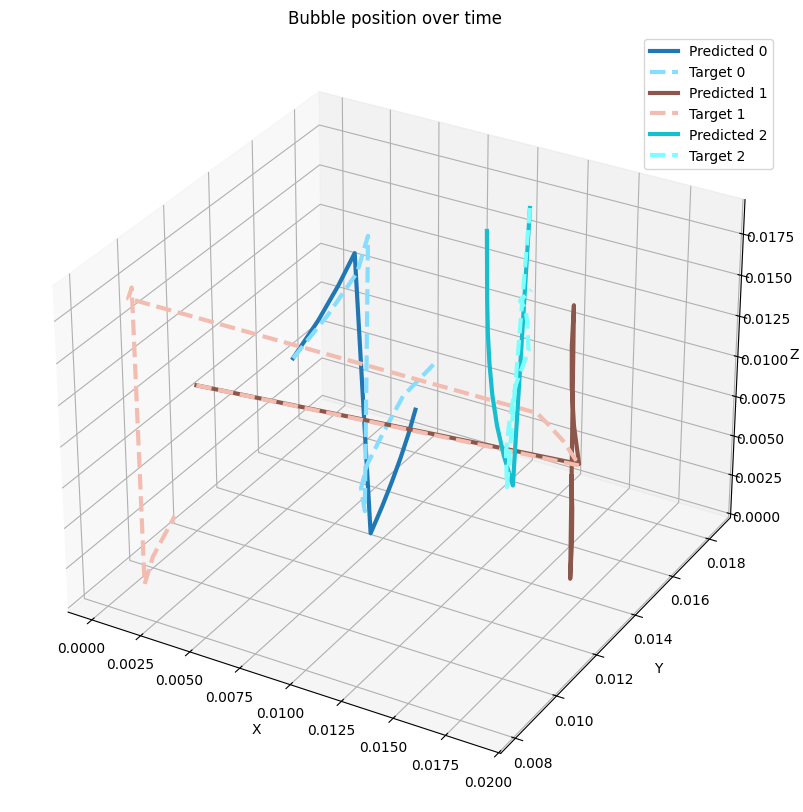

/var/folders/rb/wmrnk95s19s54kfvkb8zgwcm0000gn/T/ipykernel_16741/168908651.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("tab10", len(bubbles_num))


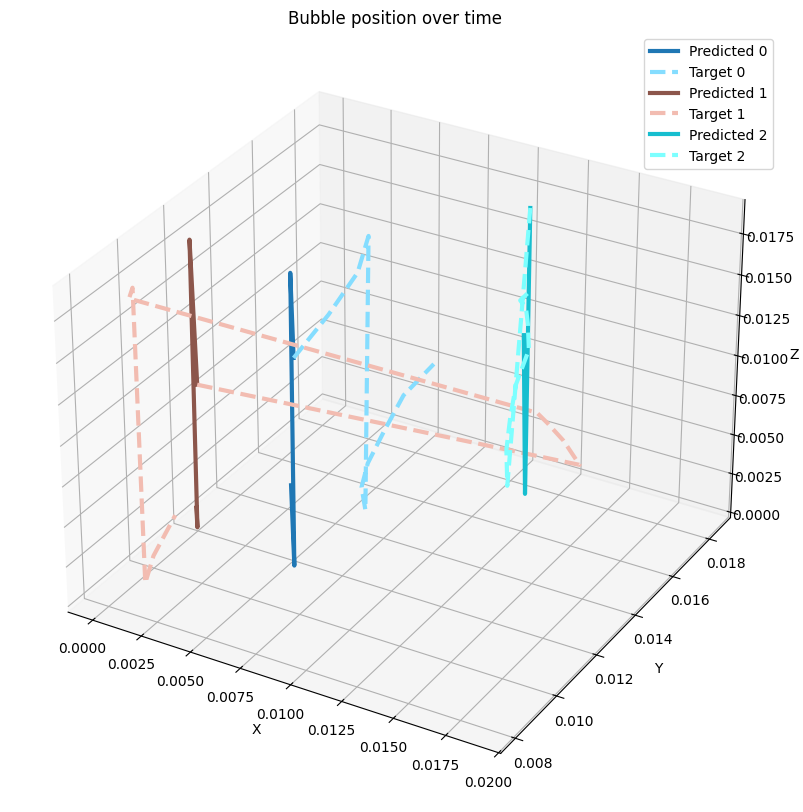

In [31]:
# Plot the trajectories of some bubbles
# bubble_indices = [i for i in range(3)]
bubble_indices = [0, 1, 2]
plot_bubbles_trajectories(predicted_trajectory, target_trajectory, bubble_indices)
plot_bubbles_trajectories(
    predicted_trajectory_baseline, target_trajectory_baseline, bubble_indices
)

In [32]:
def compare_bubble_shape(
    predicted_trajectory, target_trajectory, bubble_index, time_step_index
):
    """
    Plot the shape of the bubble at a specific time step showing the predicted,
    target, and their intersection in side-by-side views.
    Args:
        predicted_trajectory (DataFrame): The predicted trajectory.
        target_trajectory (DataFrame): The target trajectory.
        bubble_index (int): The index of the bubble to plot.
        time_step_index (int): The time step to plot.
    """
    orb_columns = [col for col in predicted_trajectory.columns if "orb_" in col]

    # Extracting the specific time step from the DataFrame
    filter_pred = (predicted_trajectory["bub_num"] == bubble_index) & (
        predicted_trajectory["time [s]"]
        == predicted_trajectory["time [s]"].unique()[time_step_index]
    )
    filter_target = (target_trajectory["bub_num"] == bubble_index) & (
        target_trajectory["time [s]"]
        == target_trajectory["time [s]"].unique()[time_step_index]
    )

    pred_orbs = predicted_trajectory.loc[filter_pred, orb_columns].values.flatten()
    target_orbs = target_trajectory.loc[filter_target, orb_columns].values.flatten()

    # Assume stl_maker creates an STL model from orbitals
    stl_model_predicted = stl_maker(pred_orbs, [100, 100])
    stl_model_target = stl_maker(target_orbs, [100, 100])

    # Initialize Plotter with three viewports
    pl = pv.Plotter(shape=(1, 2))

    # Add the predicted mesh to the first viewport
    pl.subplot(0, 0)
    pl.add_mesh(stl_model_predicted, color="magenta", show_edges=True)
    pl.add_axes()
    pl.add_title("Predicted")

    # Add the target mesh to the second viewport
    pl.subplot(0, 1)
    pl.add_mesh(stl_model_target, color="blue", show_edges=True)
    pl.add_axes()
    pl.add_title("Target")

    # Show the plot
    pl.show()

In [33]:
# Example usage of the function
bubble_index = 5
time_step_index = 4

compare_bubble_shape(
    predicted_trajectory,
    target_trajectory,
    bubble_index=bubble_index,
    time_step_index=time_step_index,
)

compare_bubble_shape(
    predicted_trajectory_baseline,
    target_trajectory_baseline,
    bubble_index=bubble_index,
    time_step_index=time_step_index,
)

Widget(value='<iframe src="http://localhost:62851/index.html?ui=P_0x313163710_0&reconnect=auto" class="pyvista…

Widget(value='<iframe src="http://localhost:62851/index.html?ui=P_0x316815ca0_1&reconnect=auto" class="pyvista…

In [34]:
def plot_orb_weights(predicted_trajectory, target_trajectory, bubble_index, orb_index):
    """
    Plot the orbital weights for the predicted and target trajectories over time.
    Args:
        predicted_trajectory (DataFrame): The predicted trajectory.
        target_trajectory (DataFrame): The target trajectory.
        bubble_index (int): The index of the bubble to plot.
        num_orbs (int): The number of orbital attributes to plot.
    """
    orb_columns = [col for col in predicted_trajectory.columns if "orb_" in col]

    # Filter the DataFrame to get the trajectories of the specified bubble
    filter_pred = predicted_trajectory[predicted_trajectory["bub_num"] == bubble_index]
    filter_target = target_trajectory[target_trajectory["bub_num"] == bubble_index]

    # Plot the orbital weights for the predicted and target trajectories
    fig, ax = plt.subplots(figsize=(20, 10))

    colormap = plt.cm.get_cmap("tab10", len(orb_index))

    for idx, orb_idx in enumerate(orb_index):
        color = colormap(idx)
        target_color = adjust_color(color, amount=0.4)

        ax.plot(
            filter_pred["time [s]"],
            filter_pred[orb_columns[orb_idx]],
            label=f"Predicted orb_{orb_idx}",
            color=color,
            linewidth=2,
        )
        ax.plot(
            filter_target["time [s]"],
            filter_target[orb_columns[orb_idx]],
            label=f"Target orb_{orb_idx}",
            linestyle="--",
            color=target_color,
            linewidth=2,
        )

    ax.set_title("Orbital weights over time")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Orbital weights")
    ax.legend()

    plt.show()

/var/folders/rb/wmrnk95s19s54kfvkb8zgwcm0000gn/T/ipykernel_16741/2877021852.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("tab10", len(orb_index))


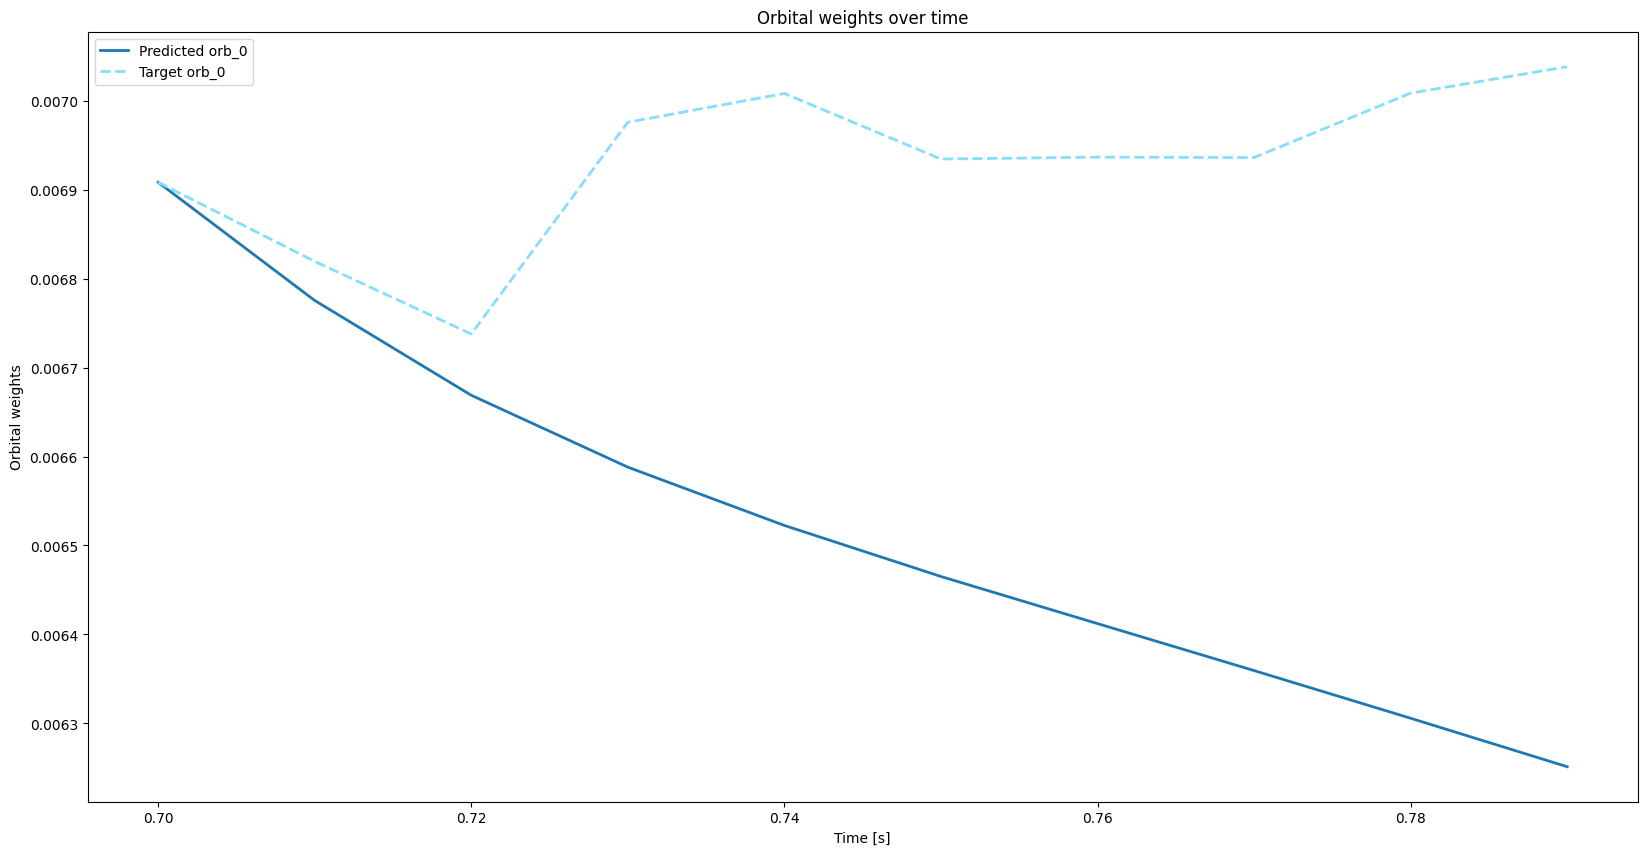

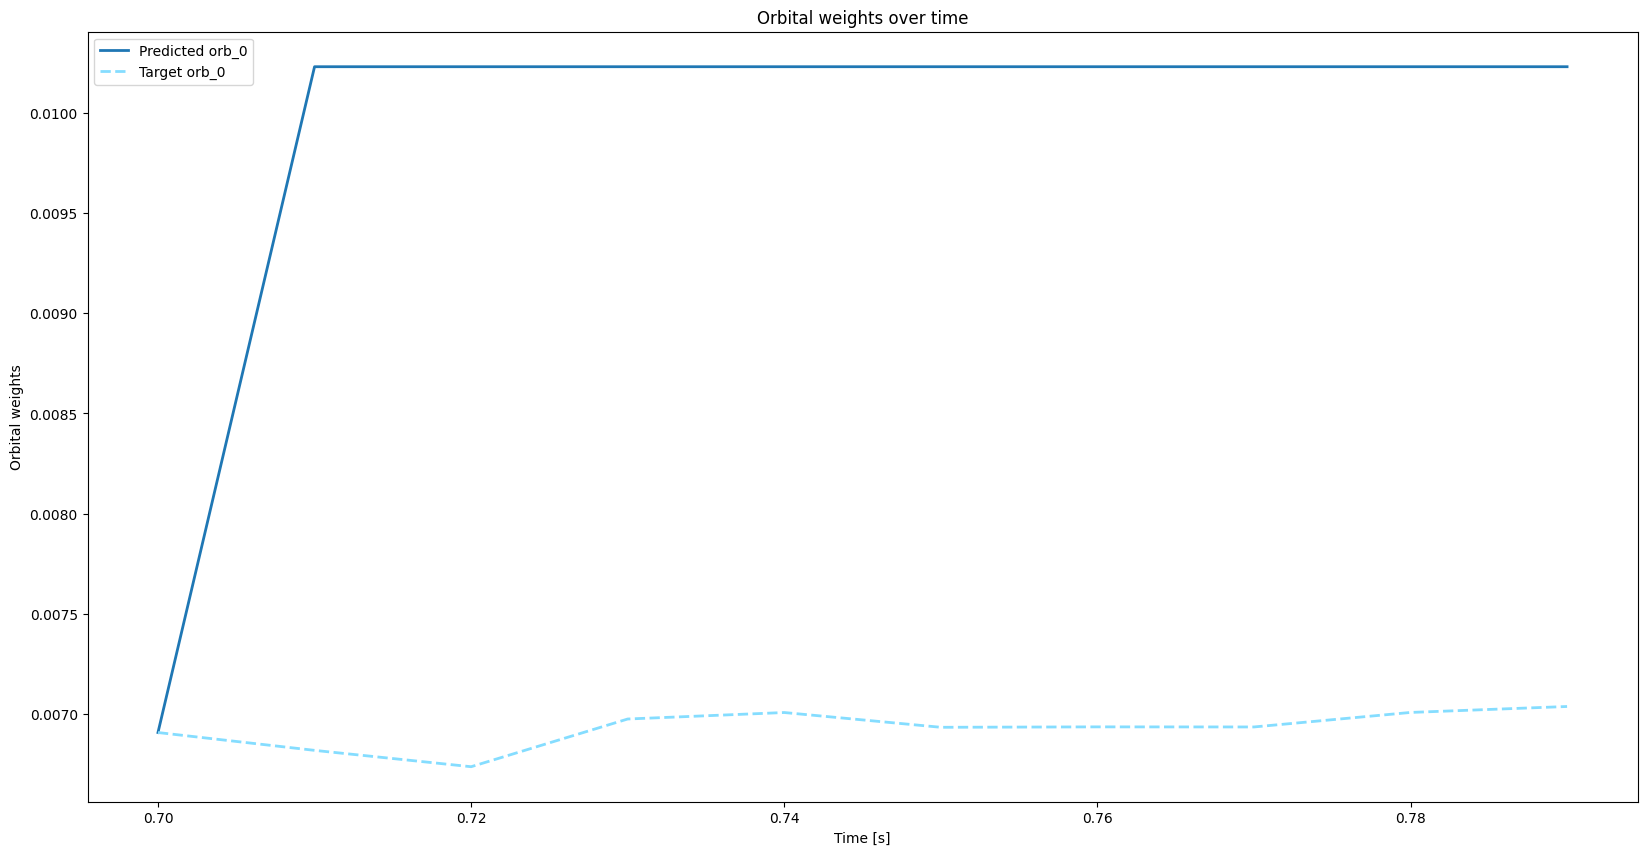

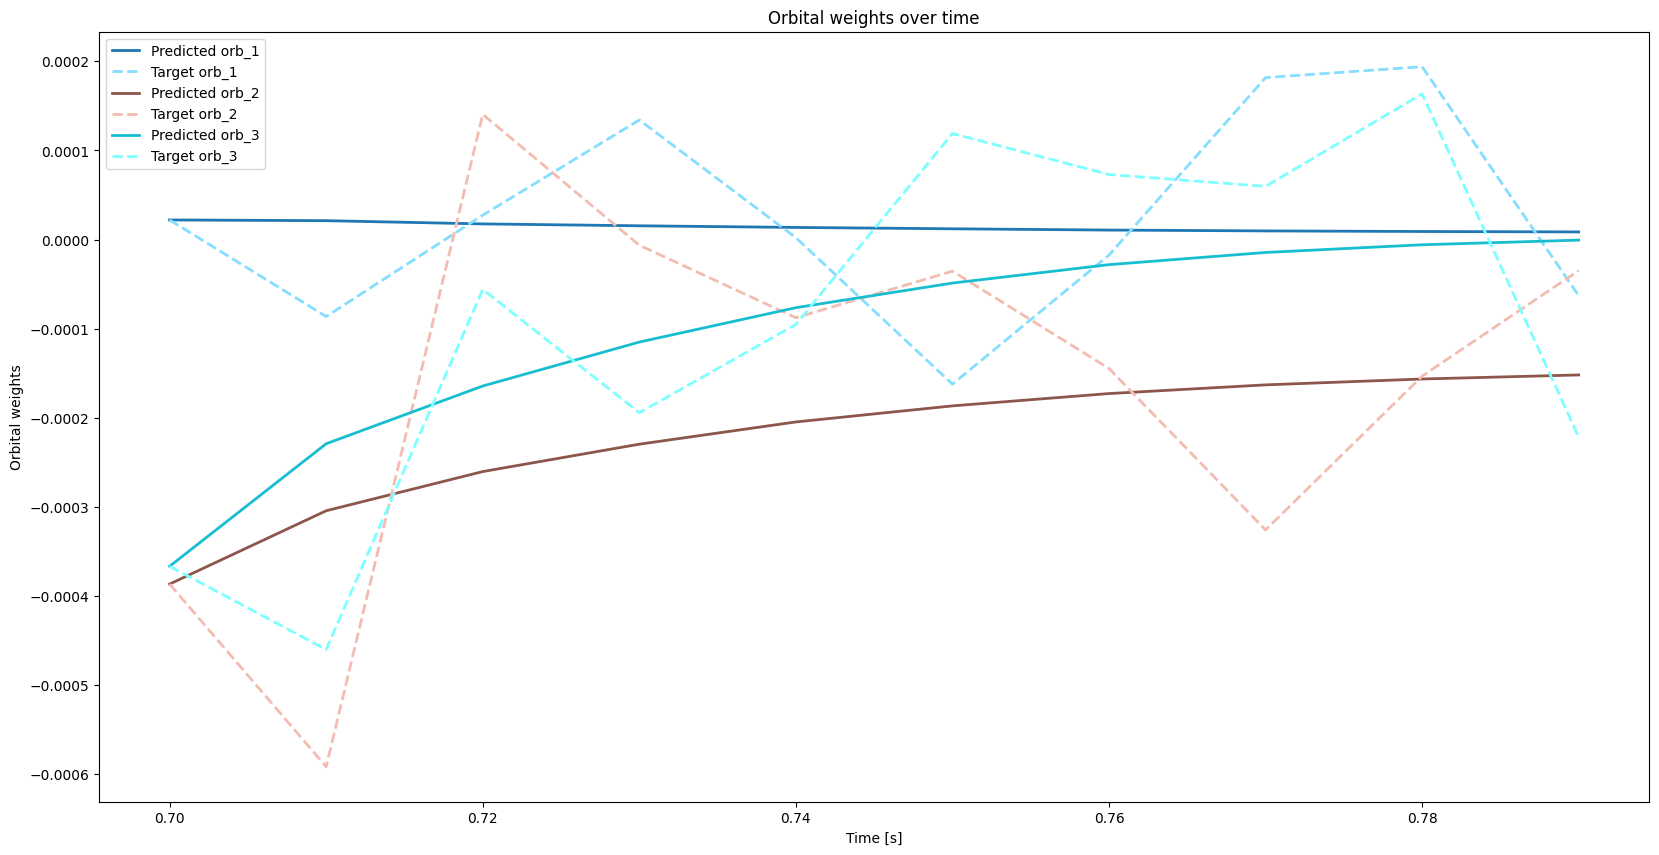

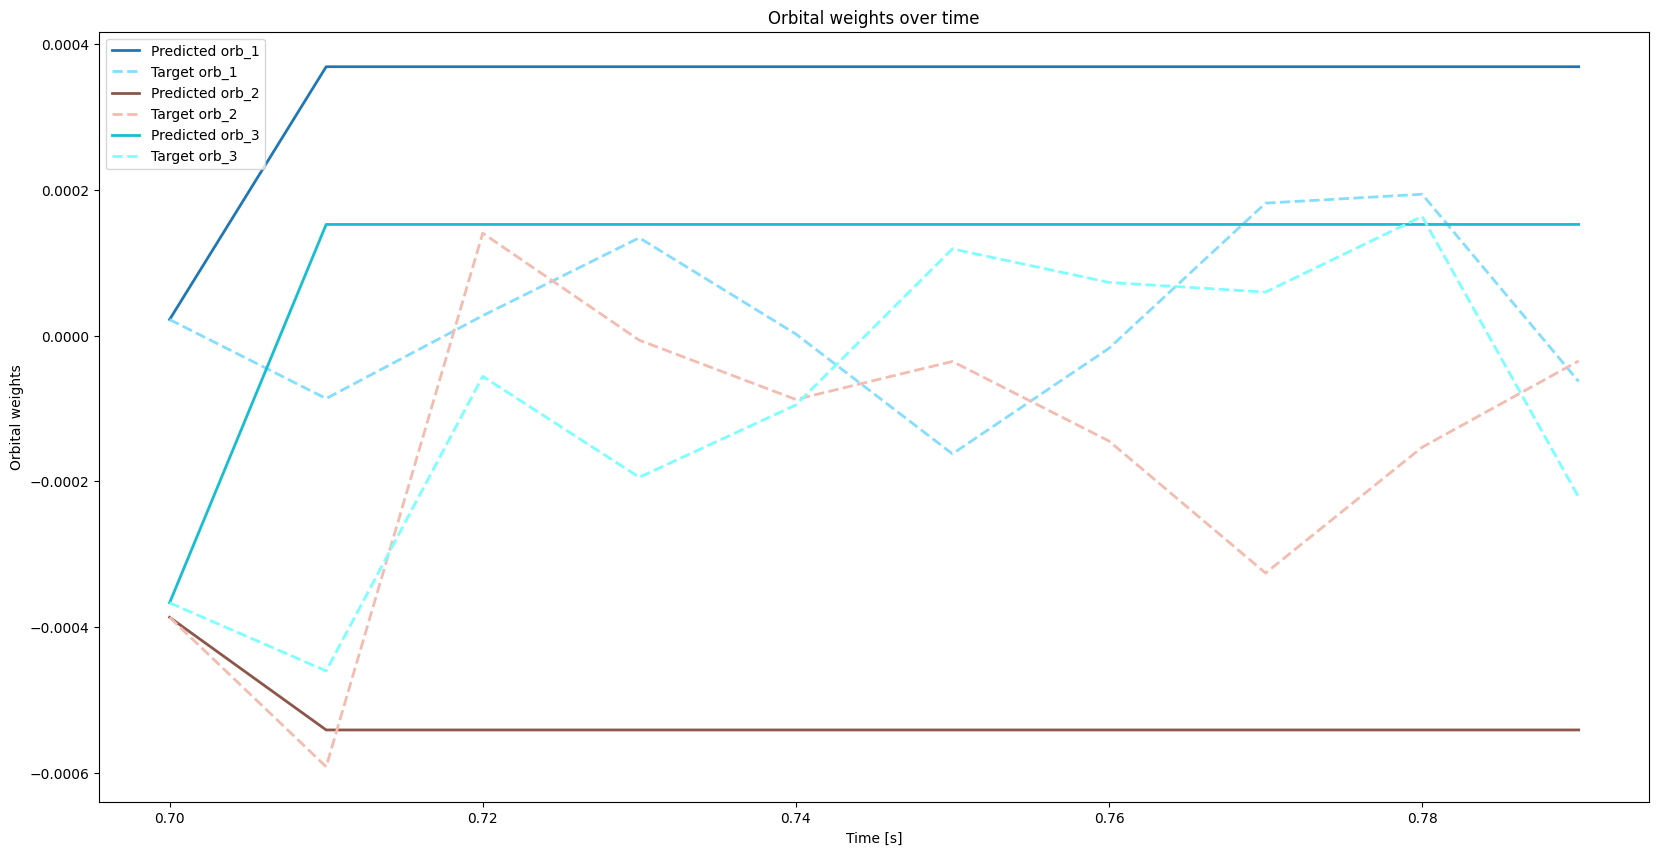

In [36]:
# Plot the orbital weights for the predicted and target trajectories of a bubble over time for a subset of orbital attributes
orb_index = [0]

plot_orb_weights(
    predicted_trajectory,
    target_trajectory,
    bubble_index=bubble_index,
    orb_index=orb_index,
)

plot_orb_weights(
    predicted_trajectory_baseline,
    target_trajectory_baseline,
    bubble_index=bubble_index,
    orb_index=orb_index,
)


orb_index = [1, 2, 3]
plot_orb_weights(
    predicted_trajectory,
    target_trajectory,
    bubble_index=bubble_index,
    orb_index=orb_index,
)

plot_orb_weights(
    predicted_trajectory_baseline,
    target_trajectory_baseline,
    bubble_index=bubble_index,
    orb_index=orb_index,
)